#### Imports

In [1]:
import os
import sys
import pandas as pd
from datetime import timedelta
from auto_ts import auto_timeseries
import numpy as np
import dill
import talib
import h2o
from h2o.automl import H2OAutoML
from sklearn.preprocessing import MinMaxScaler

# Verifica la ruta absoluta
ruta = os.path.abspath('/Users/mmarchetta/Desktop/Tesis-2024/data-obtention')
sys.path.append(ruta)

#TODO: eliminar la ejecucion del codigo automaticamente de este file
from dataset_builder import generar_dataset

Importing plotly failed. Interactive plots will not work.


Imported auto_timeseries version:0.0.92. Call by using:
model = auto_timeseries(score_type='rmse',
        time_interval='M', non_seasonal_pdq=None, seasonality=False,
        seasonal_period=12, model_type=['best'], verbose=2, dask_xgboost_flag=0)
model.fit(traindata, ts_column,target)
model.predict(testdata, model='best')



[nltk_data] Error loading vader_lexicon: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:997)>


#### Lectura del dataset

In [2]:
pd.set_option('display.float_format', lambda x: '%.2f' % x)
pd.set_option('display.max_columns', None)

In [3]:
columns = [
    # 'Open_time',
    'Open',
    'High',
    'Low',
    'SMA_20',
    'EMA_20',
    'Upper_Band',
    'Middle_Band',
    'Lower_Band',
    'RSI',
    'MACD',
    'Signal',
    'ADX',
    'SlowK',
    'SlowD',
    'CCI',
    'ATR',
    # 'MFI'
]

In [4]:
complete_dataset = pd.read_csv('final_dataset.csv') 

In [5]:
display(complete_dataset.tail())

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
982,2024-06-05,7.18,7.30,7.15,7.25,2836358.18,20489701.47,66081.00,70537.83,71758.00,70383.66,71108.00,28703.18,2040073765.87,1055115.00,3810.23,3887.47,3777.33,3865.99,273738.60,1046373693.42,645836.00,685.70,716.00,684.70,698.80,673820.57,471592896.68,516891.00,7.25,7.17,7.70,7.25,6.80,51.82,-0.02,-0.01,14.24,35.25,27.93,3.94,0.32,40.22,18.00,27.00,27408.00,pos,666.00,292.00,137.00,237.00,79.96,pos,384.00,186.00,76.00,122.00,58.47,neg,2.00,1.00,1.00,0.00,-0.29,34.00,223.00,185.00,40000.00,Lateral
983,2024-06-06,7.25,7.29,7.06,7.14,2433999.18,17531588.67,59115.00,71108.00,71700.00,70117.64,70799.06,21842.00,1551467659.15,900226.00,3866.00,3878.60,3760.00,3813.46,237504.19,910751773.18,525050.00,698.80,721.80,692.00,711.20,544042.96,383971667.05,424589.00,7.25,7.17,7.70,7.25,6.80,49.02,-0.02,-0.01,13.91,39.88,33.79,-22.62,0.32,45.41,12.00,18.00,27918.00,pos,526.00,240.00,87.00,199.00,78.16,pos,370.00,197.00,55.00,118.00,78.01,neu,0.00,0.00,0.00,0.00,0.00,35.00,174.00,138.00,36000.00,Lateral
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista


#### Obtengo la informacion del ultimo dia que paso

In [6]:
ultima_fecha = pd.to_datetime(complete_dataset['Open_time'].iloc[-1])
nueva_fecha = ultima_fecha + pd.Timedelta(days=1)

display(ultima_fecha)
display(nueva_fecha)

Timestamp('2024-06-09 00:00:00')

Timestamp('2024-06-10 00:00:00')

In [7]:
complete_dataset.tail()

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
982,2024-06-05,7.18,7.30,7.15,7.25,2836358.18,20489701.47,66081.00,70537.83,71758.00,70383.66,71108.00,28703.18,2040073765.87,1055115.00,3810.23,3887.47,3777.33,3865.99,273738.60,1046373693.42,645836.00,685.70,716.00,684.70,698.80,673820.57,471592896.68,516891.00,7.25,7.17,7.70,7.25,6.80,51.82,-0.02,-0.01,14.24,35.25,27.93,3.94,0.32,40.22,18.00,27.00,27408.00,pos,666.00,292.00,137.00,237.00,79.96,pos,384.00,186.00,76.00,122.00,58.47,neg,2.00,1.00,1.00,0.00,-0.29,34.00,223.00,185.00,40000.00,Lateral
983,2024-06-06,7.25,7.29,7.06,7.14,2433999.18,17531588.67,59115.00,71108.00,71700.00,70117.64,70799.06,21842.00,1551467659.15,900226.00,3866.00,3878.60,3760.00,3813.46,237504.19,910751773.18,525050.00,698.80,721.80,692.00,711.20,544042.96,383971667.05,424589.00,7.25,7.17,7.70,7.25,6.80,49.02,-0.02,-0.01,13.91,39.88,33.79,-22.62,0.32,45.41,12.00,18.00,27918.00,pos,526.00,240.00,87.00,199.00,78.16,pos,370.00,197.00,55.00,118.00,78.01,neu,0.00,0.00,0.00,0.00,0.00,35.00,174.00,138.00,36000.00,Lateral
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista


#### Obtengo la informacion de ese dia

In [8]:
margin_days = 40
wanted_previous_dates = 1
binance_symbol = 'DOTUSDT'
coinbase_symbol = 'DOT-USD'
interval = '1d'
n_days_to_predict = 10

start_time = int((nueva_fecha - timedelta(days=(margin_days + wanted_previous_dates + 1))).timestamp() * 1000)
end_time = int((nueva_fecha + timedelta(days=(1))).timestamp() * 1000)

start_date = nueva_fecha - timedelta(days=(wanted_previous_dates))
end_date = nueva_fecha + timedelta(days=1)

In [9]:
dataset_nuevo_registro = generar_dataset(interval, start_time, end_time, start_date, end_date, coinbase_symbol, binance_symbol, ['BTCUSDT', 'ETHUSDT', 'BNBUSDT'])

In [10]:
dataset_nuevo_registro['buy_1000x_high_coinbase'] = 0
dataset_nuevo_registro['Cantidad_pos'] = 0
dataset_nuevo_registro['Cantidad_neg'] = 0
dataset_nuevo_registro['Cantidad_neu'] = 0
dataset_nuevo_registro['Compound_total'] = 0
dataset_nuevo_registro['Sentimiento_coin'] = 0
dataset_nuevo_registro['Tweets_Utilizados_coin'] = 0
dataset_nuevo_registro['Cantidad_pos_coin'] = 0
dataset_nuevo_registro['Cantidad_neg_coin'] = 0
dataset_nuevo_registro['Cantidad_neu_coin'] = 0
dataset_nuevo_registro['Compound_total_coin'] = 0
dataset_nuevo_registro['Sentimiento_referentes'] = 0
dataset_nuevo_registro['Tweets_Utilizados_referentes'] = 0
dataset_nuevo_registro['Cantidad_pos_referentes'] = 0
dataset_nuevo_registro['Cantidad_neg_referentes'] = 0
dataset_nuevo_registro['Cantidad_neu_referentes'] = 0
dataset_nuevo_registro['Compound_total_referentes'] = 0
dataset_nuevo_registro['Tweets_Utilizados_whale_alert'] = 0
dataset_nuevo_registro['sell_1000x_high_coinbase'] = 0
dataset_nuevo_registro['total_trades_coinbase'] = 0
dataset_nuevo_registro['Sentimiento'] = 0
dataset_nuevo_registro['Tweets_Utilizados'] = 0
dataset_nuevo_registro['Compound total'] = 0
dataset_nuevo_registro['Compound total coin'] = 0
dataset_nuevo_registro['Compound total referentes'] = 0
dataset_nuevo_registro['Buy_1000x_high'] = 0
dataset_nuevo_registro['Buy_1000x_high'] = 0
dataset_nuevo_registro['total_trades_binance'] = 0
dataset_nuevo_registro['sell_1000x_high'] = 0

In [11]:
ultimo_close = complete_dataset['Close'].iloc[-1]
nuevo_registro = dataset_nuevo_registro[:].iloc[-2] #por algun motivo me trae los datos del dia actual hasta el momento tmb
display(ultimo_close)
display(nuevo_registro)

6.527

Open_time                    2024-06-10 00:00:00
Open                                  6.52700000
High                                  6.58200000
Low                                   6.35700000
Close                                 6.50600000
                                    ...         
Compound total coin                            0
Compound total referentes                      0
Buy_1000x_high                                 0
total_trades_binance                           0
sell_1000x_high                                0
Name: 42, Length: 71, dtype: object

In [12]:
def categorizar_tendencia(cambio):
    if cambio > 0.015:
        return 'Alcista'
    elif -0.015 <= cambio <= 0.015:
        return 'Lateral'
    elif cambio <= -0.015:
        return 'Bajista'

# Calcular el cambio en el precio de cierre entre dos periodos
cambio = float(nuevo_registro['Close']) - ultimo_close
percent_change = cambio / ultimo_close

# Categorizar la tendencia
tendencia = categorizar_tendencia(percent_change)

nuevo_registro['Tendencia'] = tendencia

In [13]:
display(pd.DataFrame(nuevo_registro).T)
nuevo_registro = pd.DataFrame(nuevo_registro).T

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound_total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound_total_coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound_total_referentes,Tweets_Utilizados_whale_alert,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Compound total,Compound total coin,Compound total referentes,Buy_1000x_high,total_trades_binance,sell_1000x_high,Tendencia
42,2024-06-10 00:00:00,6.52700000,6.58200000,6.35700000,6.50600000,2942181.04000000,19083975.95825000,78223,69648.15000000,70195.94000000,69172.29000000,69540.00000000,17122.66941000,1192466549.96912270,936731,3706.40000000,3713.67000000,3642.74000000,3667.85000000,156363.18460000,575211243.30527000,391165,673.10000000,674.80000000,613.30000000,625.10000000,692122.61600000,443628428.24560000,698508,7.09,6.94,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,Lateral


In [14]:
complete_dataset.dtypes

Open_time                         object
Open                             float64
High                             float64
Low                              float64
Close                            float64
                                  ...   
Tweets_Utilizados_whale_alert    float64
Buy_1000x_high                   float64
sell_1000x_high                  float64
total_trades_binance             float64
Tendencia                         object
Length: 69, dtype: object

In [15]:
# Acomodo las unidades y el formato de fecha
columns_to_convert = nuevo_registro.columns.difference(['Open_time', 'Tendencia'])
nuevo_registro[columns_to_convert] = nuevo_registro[columns_to_convert].astype(float).round(3)

nuevo_registro['Open_time'] = pd.to_datetime(nuevo_registro['Open_time']).dt.date

display(nuevo_registro)

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound_total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound_total_coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound_total_referentes,Tweets_Utilizados_whale_alert,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Compound total,Compound total coin,Compound total referentes,Buy_1000x_high,total_trades_binance,sell_1000x_high,Tendencia
42,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral


In [16]:
nuevo_registro.dtypes

Open_time                     object
Open                         float64
High                         float64
Low                          float64
Close                        float64
                              ...   
Compound total referentes    float64
Buy_1000x_high               float64
total_trades_binance         float64
sell_1000x_high              float64
Tendencia                     object
Length: 72, dtype: object

In [17]:
nuevo_df = pd.concat([complete_dataset, nuevo_registro[complete_dataset.columns]], ignore_index=True)
nuevo_df['Open_time'] = pd.to_datetime(nuevo_df['Open_time'])
nuevo_df.to_csv('final_dataset.csv', index=False) 
display(nuevo_df.tail(5))

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
983,2024-06-06,7.25,7.29,7.06,7.14,2433999.18,17531588.67,59115.00,71108.00,71700.00,70117.64,70799.06,21842.00,1551467659.15,900226.00,3866.00,3878.60,3760.00,3813.46,237504.19,910751773.18,525050.00,698.80,721.80,692.00,711.20,544042.96,383971667.05,424589.00,7.25,7.17,7.70,7.25,6.80,49.02,-0.02,-0.01,13.91,39.88,33.79,-22.62,0.32,45.41,12.00,18.00,27918.00,pos,526.00,240.00,87.00,199.00,78.16,pos,370.00,197.00,55.00,118.00,78.01,neu,0.00,0.00,0.00,0.00,0.00,35.00,174.00,138.00,36000.00,Lateral
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista
987,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral


#### Re-entreno los mejores modelos predictores de features

In [18]:
columns_to_predict = [
    # 'Open_time',
    'Open',
    'High',
    'Low',
    'Close',
]

In [19]:
features = nuevo_df[columns_to_predict]
features['timestamp'] = pd.to_datetime(nuevo_df['Open_time'], errors='coerce')
features = features[['timestamp'] + columns_to_predict]
display(features)

,timestamp,Open,High,Low,Close
0,2021-09-27,28.84,30.26,27.50,27.71
1,2021-09-28,27.72,28.38,26.14,26.31
2,2021-09-29,26.31,28.59,26.11,27.28
3,2021-09-30,27.28,28.99,27.13,28.62
4,2021-10-01,28.61,32.33,28.50,31.94
...,...,...,...,...,...
983,2024-06-06,7.25,7.29,7.06,7.14
984,2024-06-07,7.14,7.29,6.05,6.66
985,2024-06-08,6.66,6.68,6.34,6.38
986,2024-06-09,6.38,6.54,6.38,6.53


Start of Fit.....
    Target variable given as = Open
Start of loading of data.....
    Inputs: ts_column = timestamp, sep = ,, target = ['Open']
    Using given input: pandas dataframe...
    timestamp column exists in given train data...
    train data shape = (988, 4)
Alert: Could not detect strf_time_format of timestamp. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |     -1.8131307968065429      |
|           p-value           |      0.3739623791607598      |
|          #Lags Used         |             0.0              |
| Number of Observations Used |            987.0             |
|     Critical Value (1%)     |    

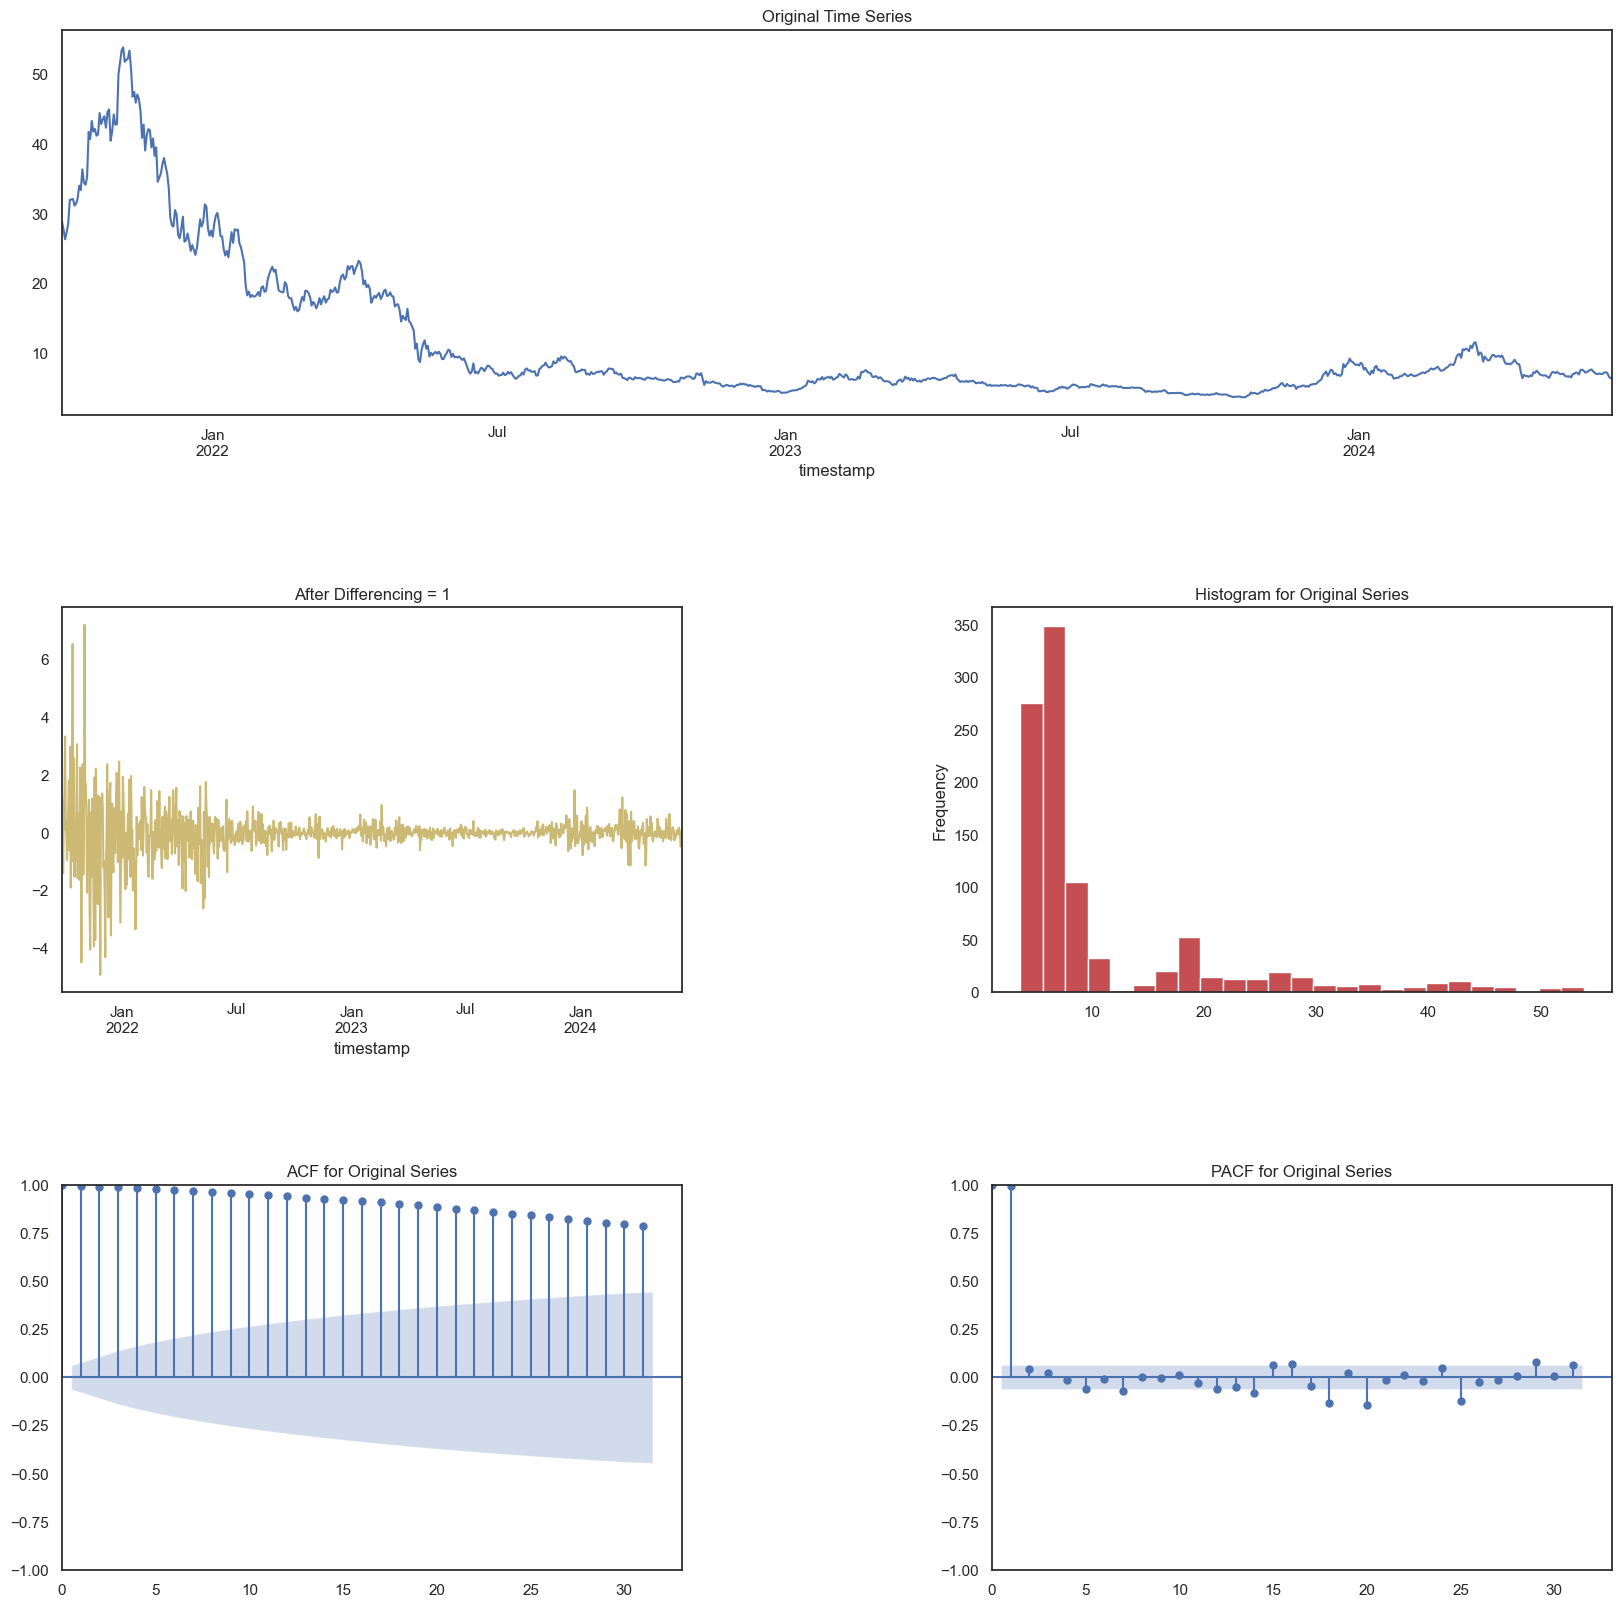

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...
Start of Fit.....
    Target variable given as = Open
Start of loading of data.....
    Inputs: ts_column = timestamp, sep = ,, target = ['Open']
    Using given input: pandas dataframe...
    timestamp column exists in given train data...
    train data shape = (988, 4)
Alert: Could not detect strf_time_format of timestamp. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


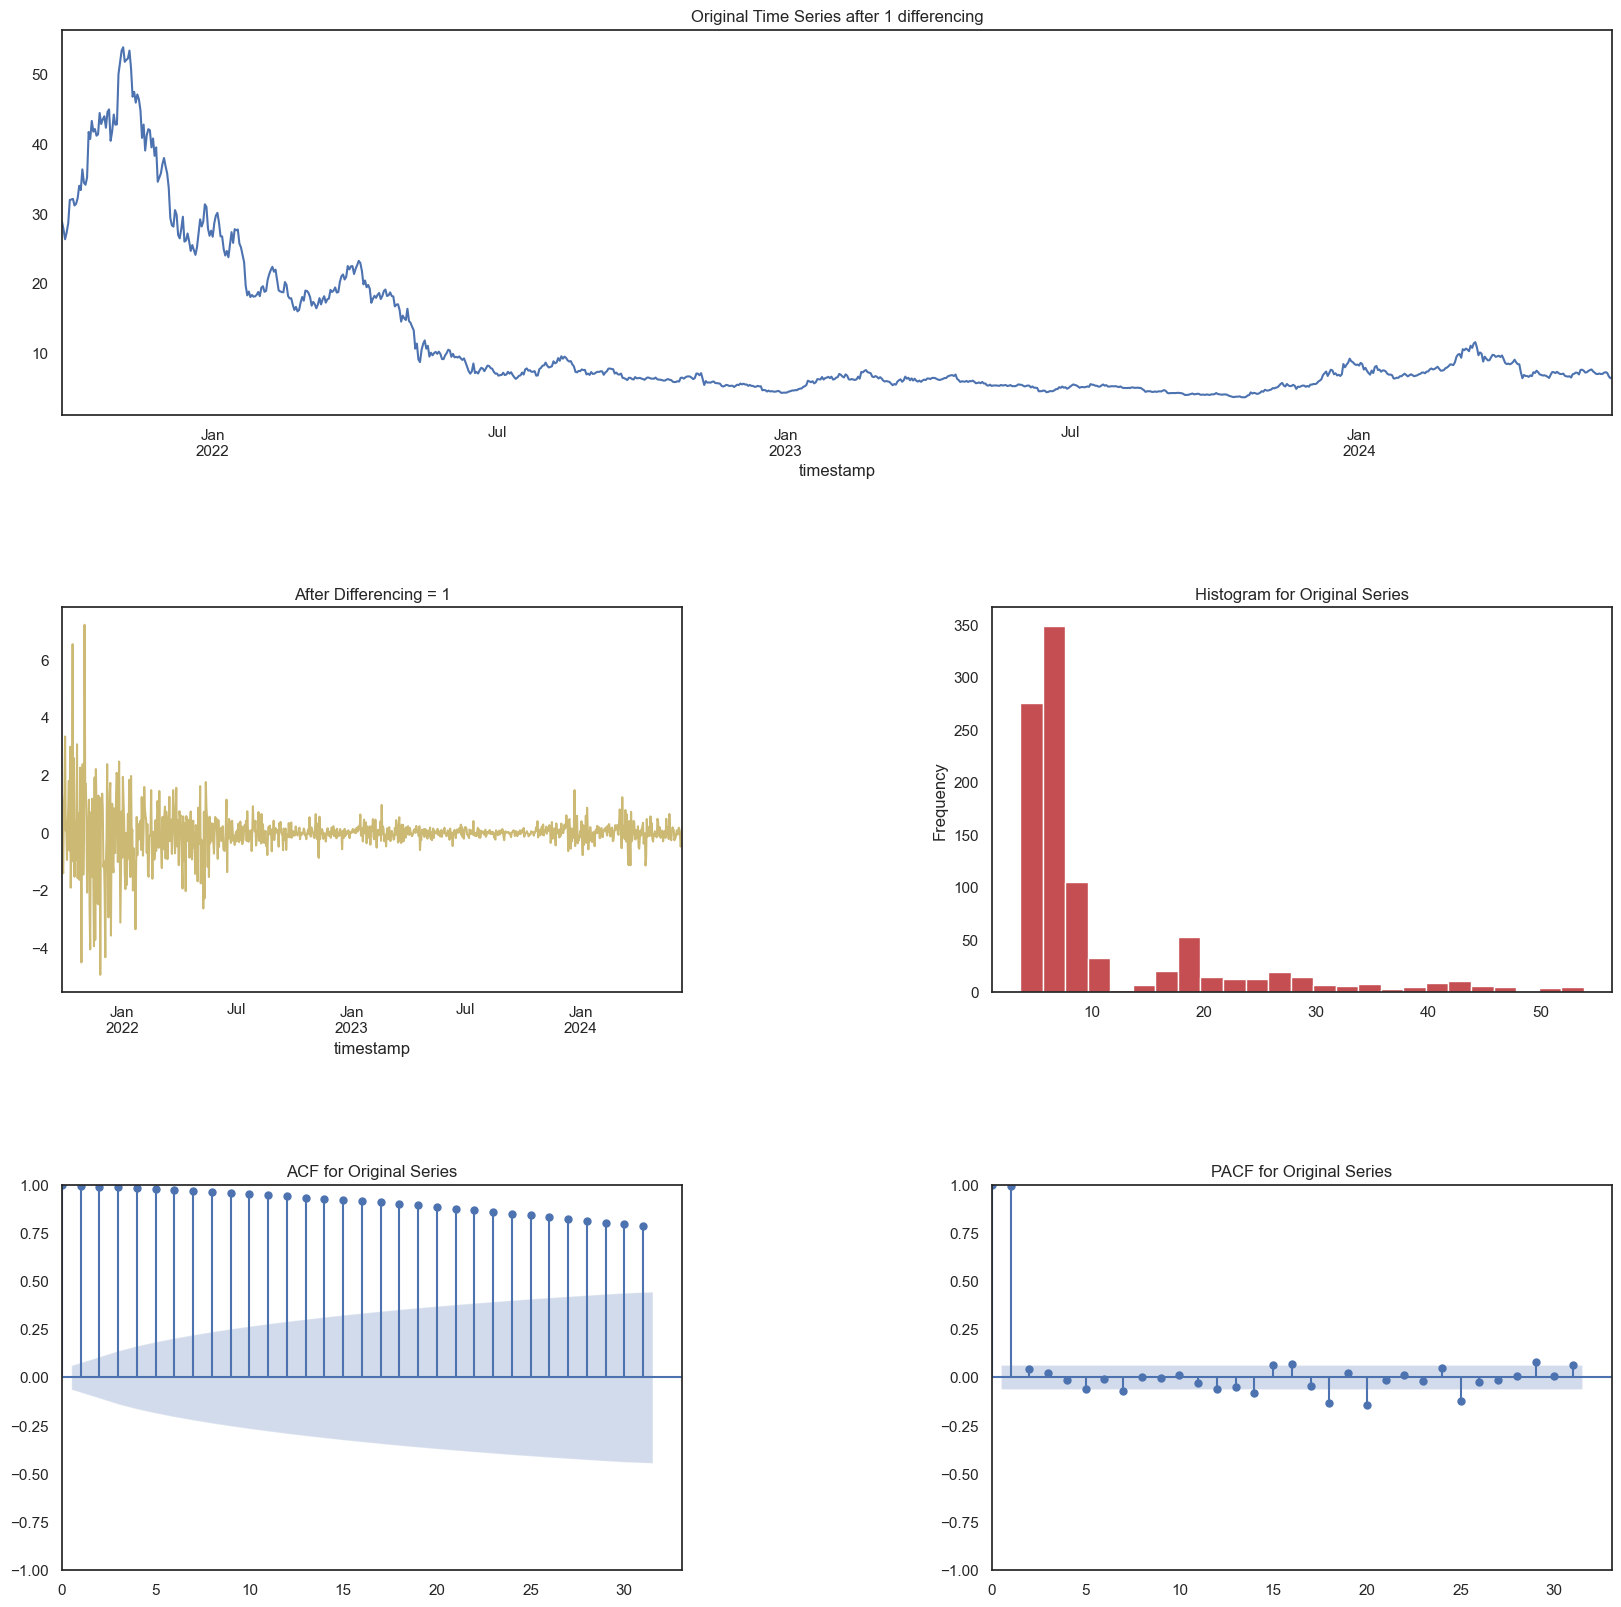

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(988, 5)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 2

Fold Number: 1 --> Train Shape: 968 Test Shape: 10


15:49:55 - cmdstanpy - INFO - Chain [1] start processing
15:49:55 - cmdstanpy - INFO - Chain [1] done processing


    RMSE = 0.70
    Std Deviation of actuals = 0.20
    Normalized RMSE (as pct of std dev) = 348%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 978 Test Shape: 10


15:49:56 - cmdstanpy - INFO - Chain [1] start processing
15:49:56 - cmdstanpy - INFO - Chain [1] done processing


Exception occurred while building Prophet model...
'DataFrame' object has no attribute 'append'
    FB Prophet may not be installed or Model is not running...


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2291.735, Time=0.37 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2292.390, Time=0.27 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2292.414, Time=0.33 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2290.484, Time=0.09 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2286.454, Time=0.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2288.225, Time=0.80 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2296.331, Time=0.31 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2294.331, Time=0.43

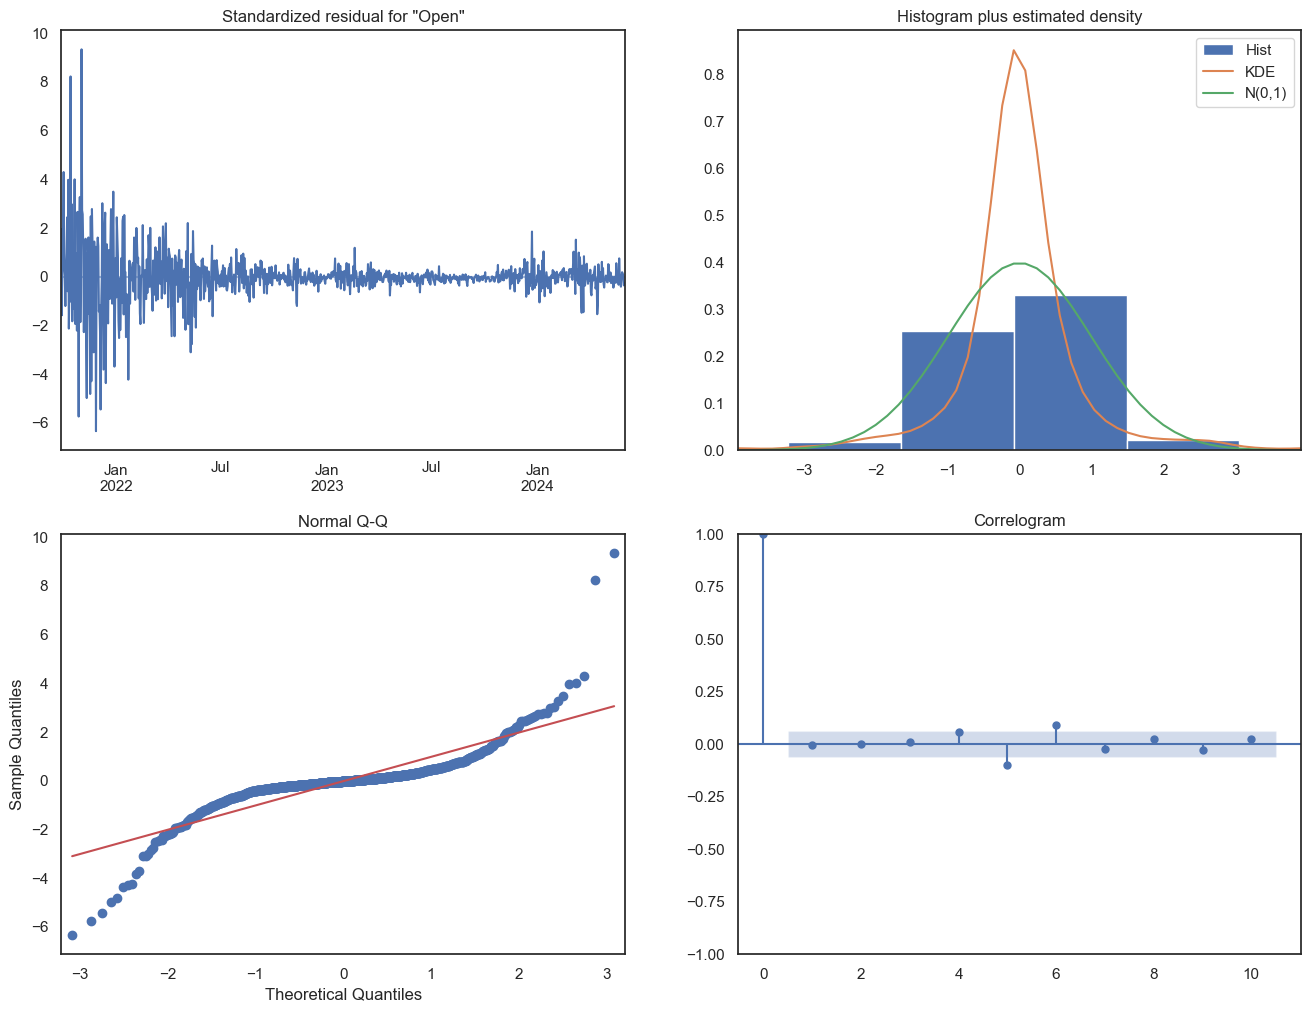

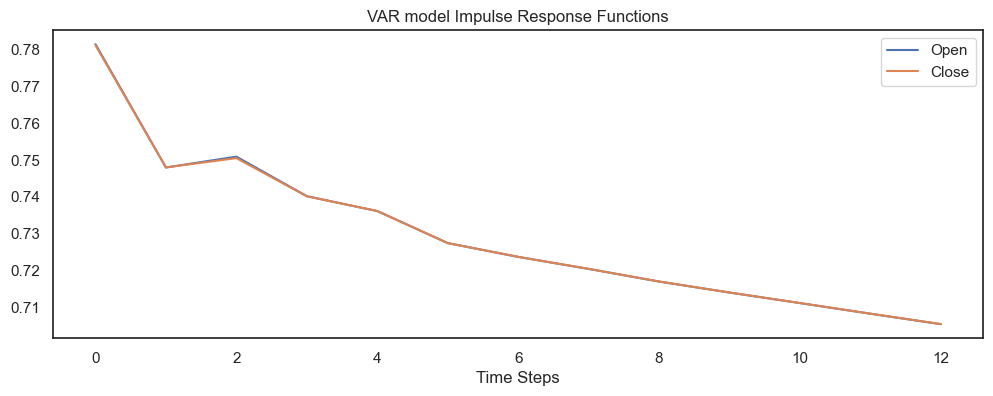

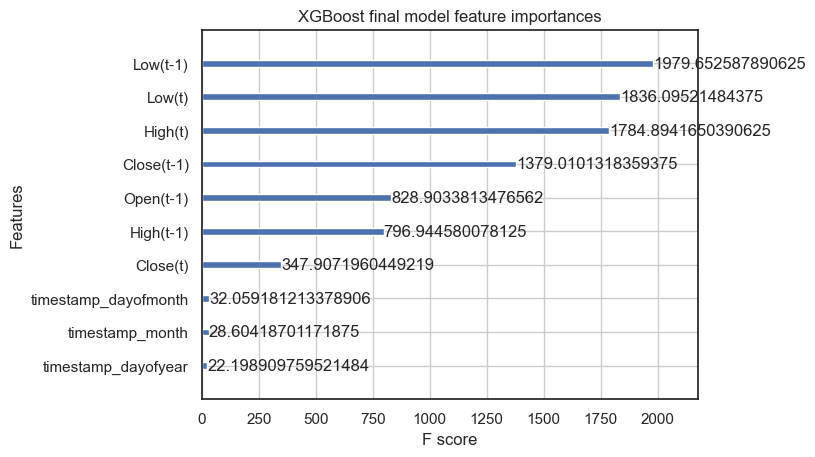

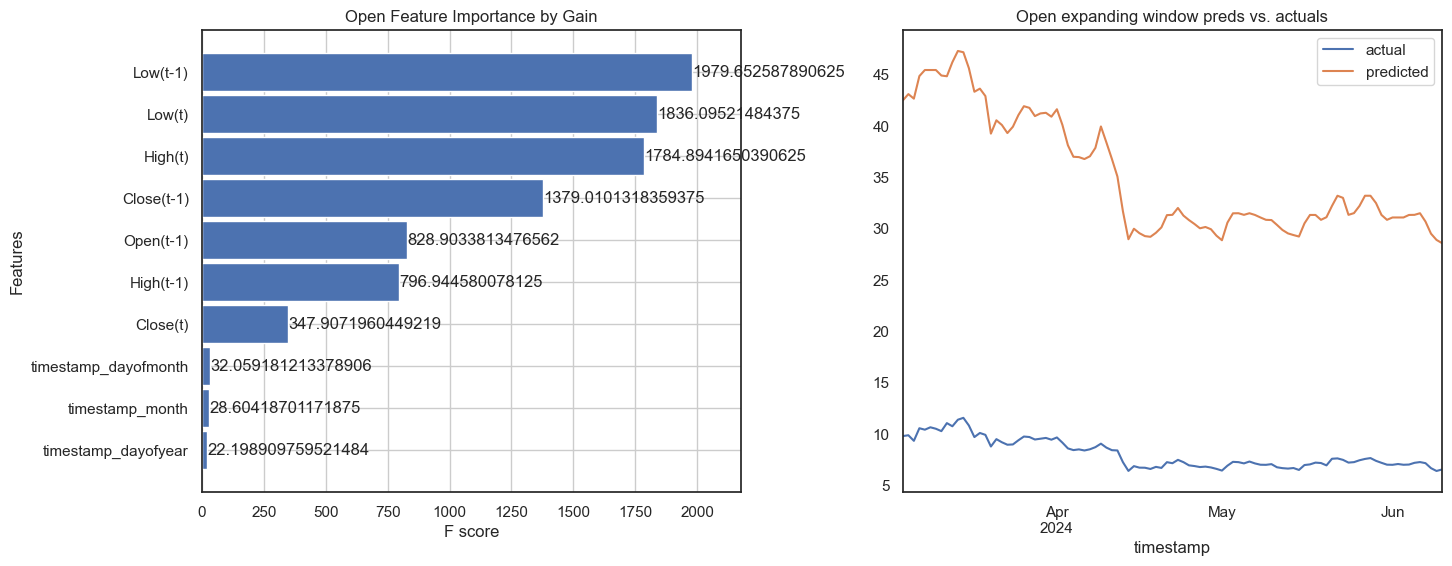

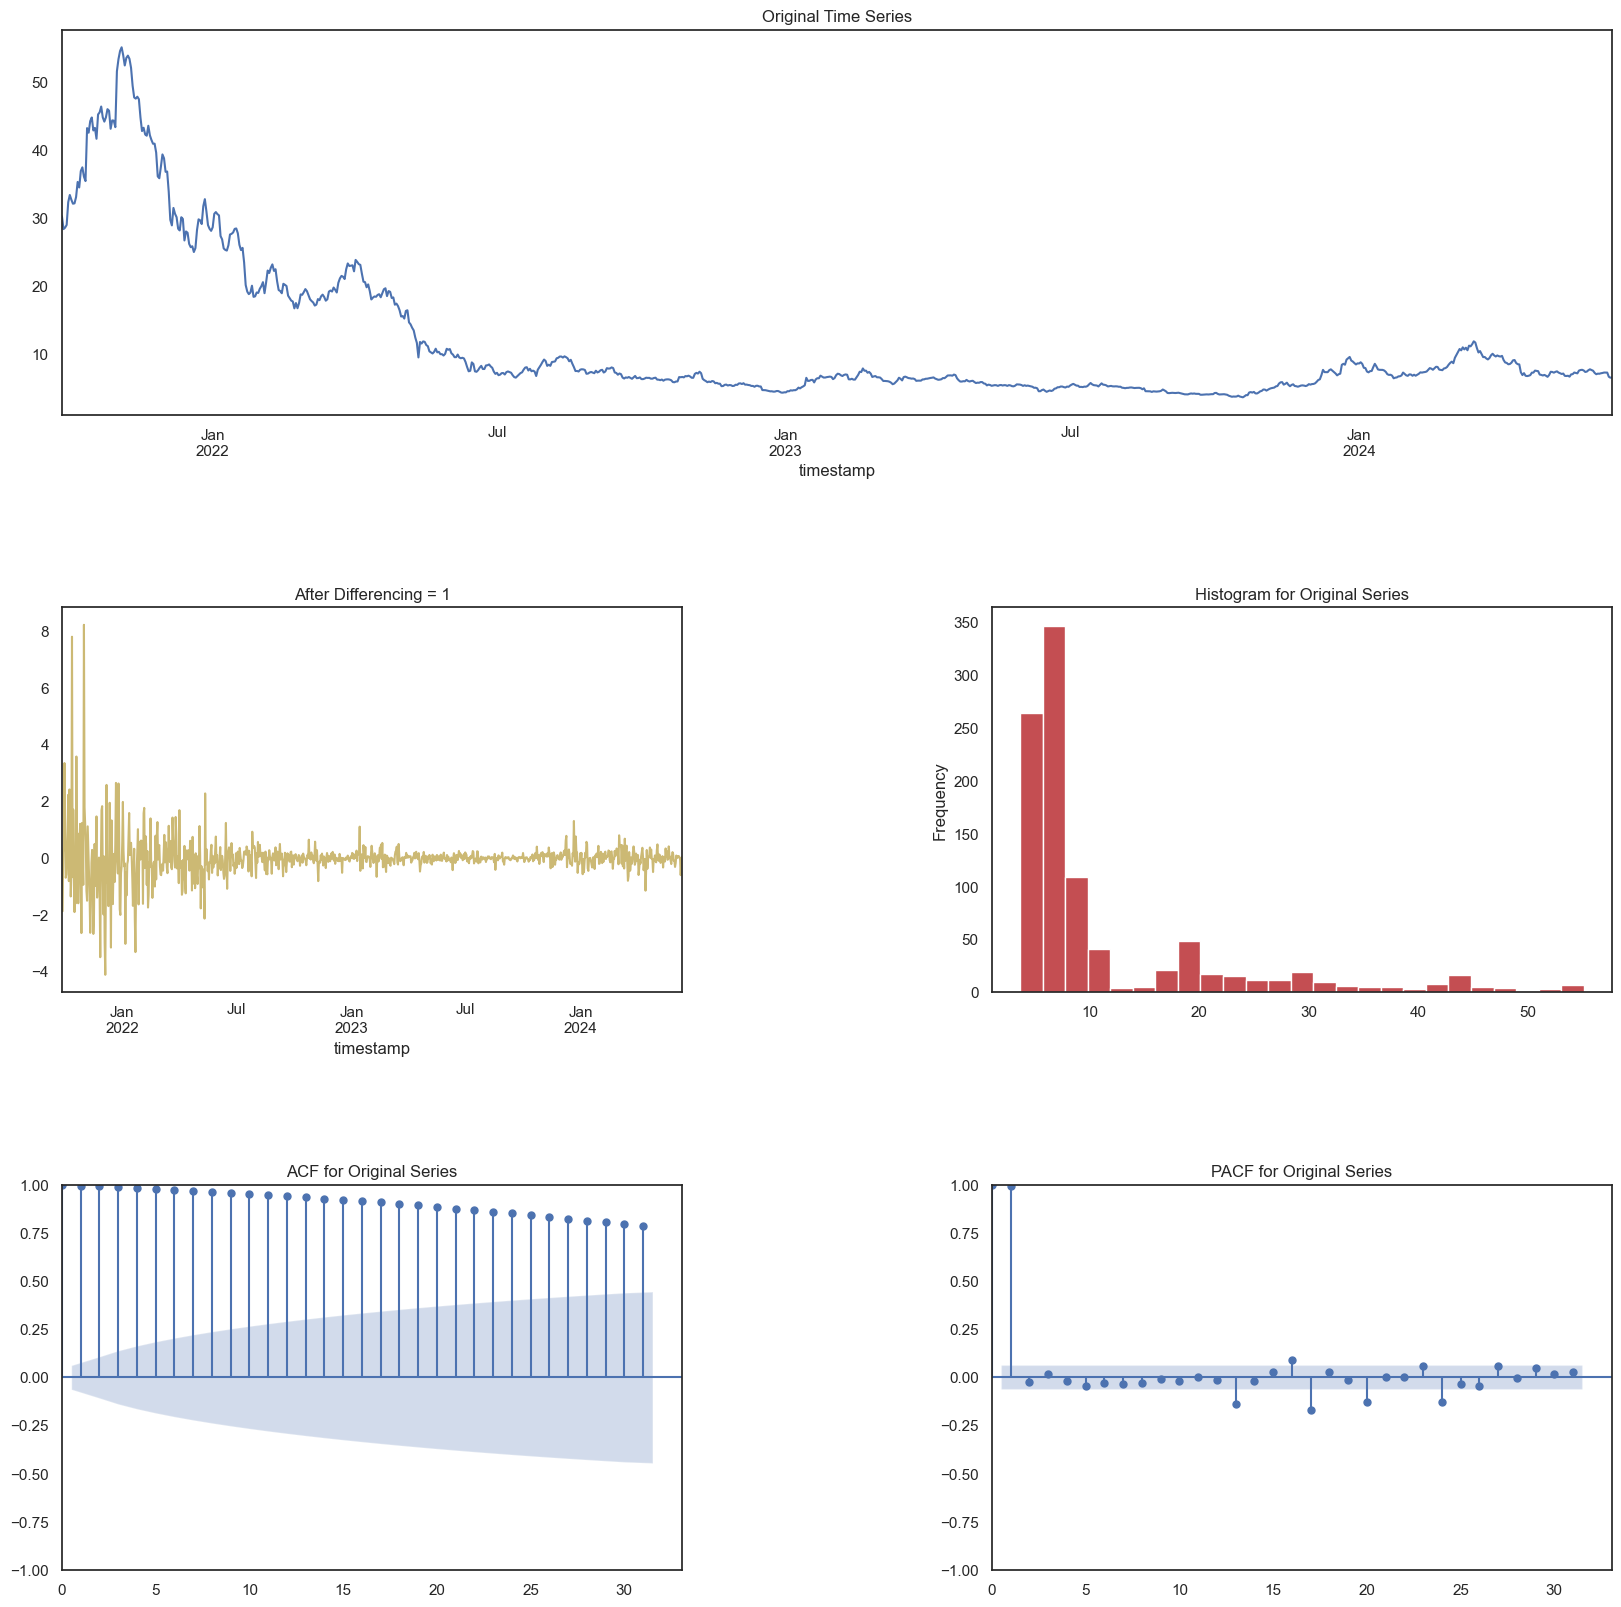

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...
Start of Fit.....
    Target variable given as = High
Start of loading of data.....
    Inputs: ts_column = timestamp, sep = ,, target = ['High']
    Using given input: pandas dataframe...
    timestamp column exists in given train data...
    train data shape = (988, 4)
Alert: Could not detect strf_time_format of timestamp. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


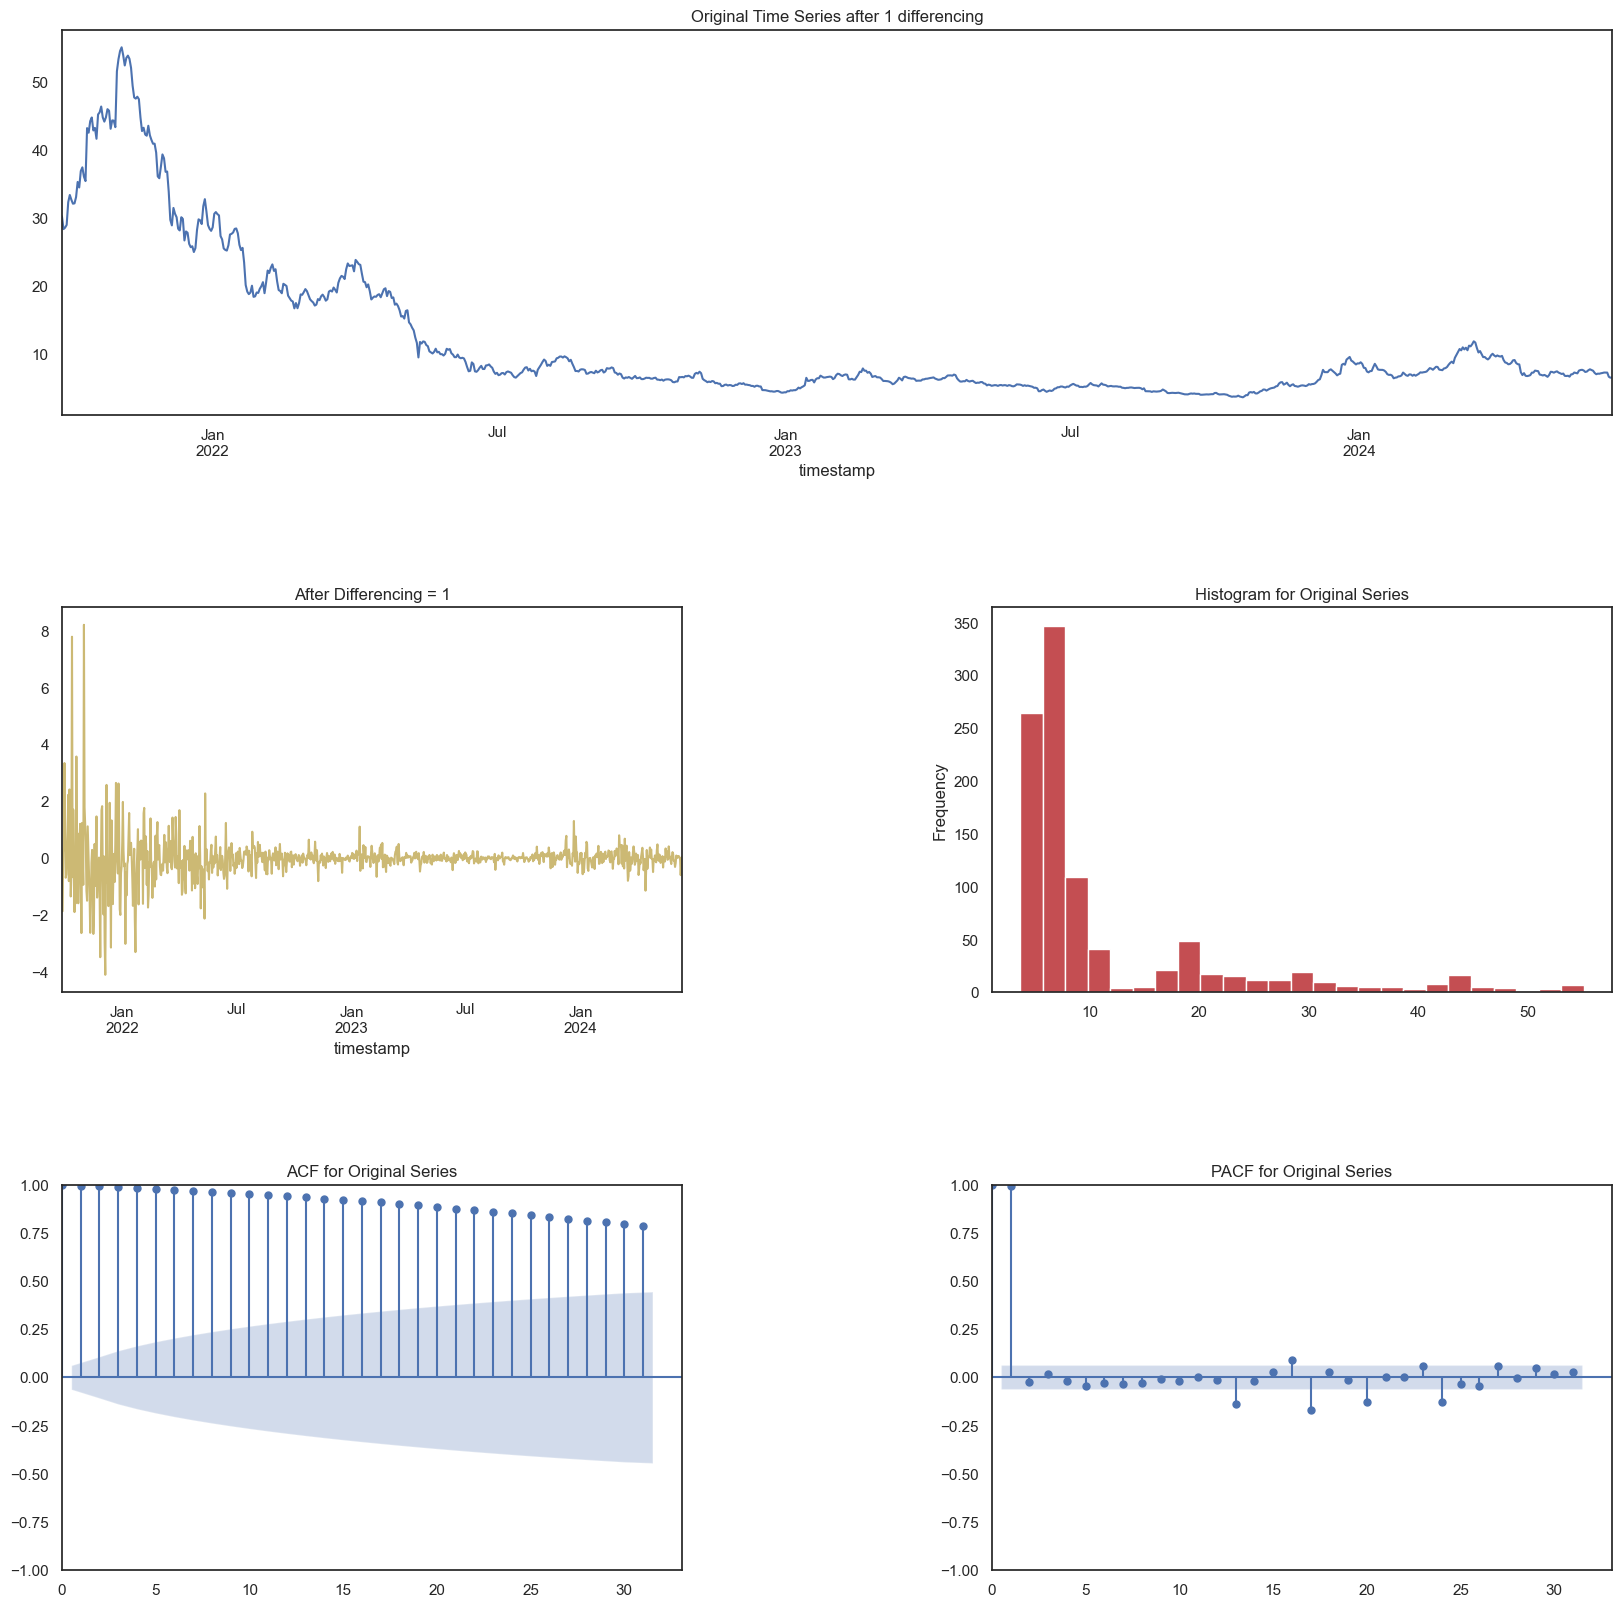

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(988, 5)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 2

Fold Number: 1 --> Train Shape: 968 Test Shape: 10


17:53:36 - cmdstanpy - INFO - Chain [1] start processing
17:53:36 - cmdstanpy - INFO - Chain [1] done processing
17:53:37 - cmdstanpy - INFO - Chain [1] start processing


    RMSE = 0.94
    Std Deviation of actuals = 0.21
    Normalized RMSE (as pct of std dev) = 437%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 978 Test Shape: 10


17:53:37 - cmdstanpy - INFO - Chain [1] done processing


Exception occurred while building Prophet model...
'DataFrame' object has no attribute 'append'
    FB Prophet may not be installed or Model is not running...


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2109.682, Time=0.16 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2100.405, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2099.061, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2108.703, Time=0.07 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2096.297, Time=0.42 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2098.081, Time=0.50 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2098.081, Time=0.90 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2098.303, Time=0.27

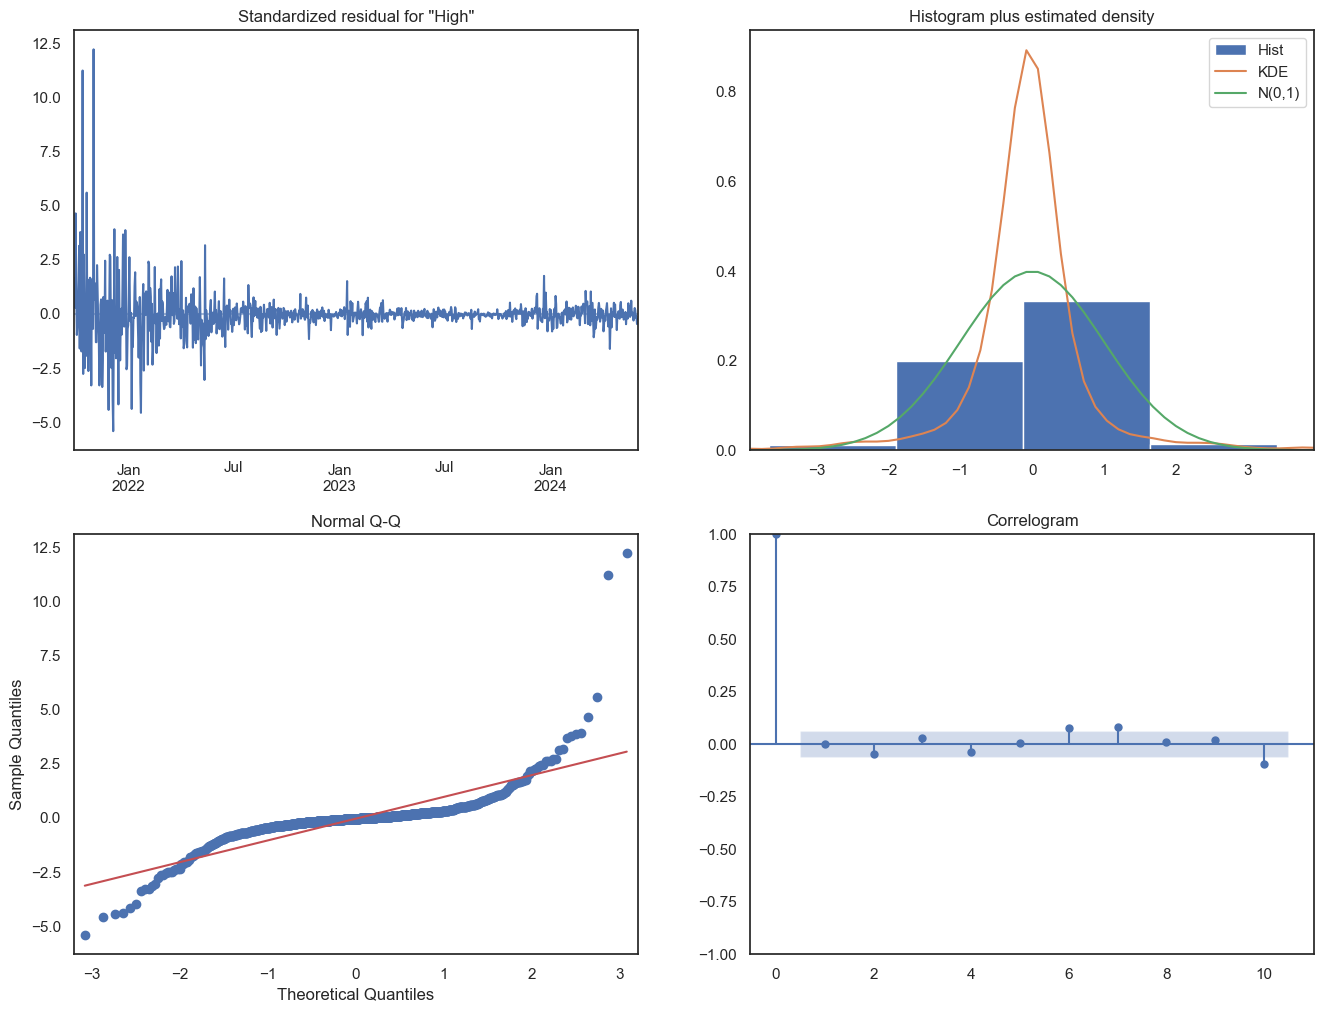

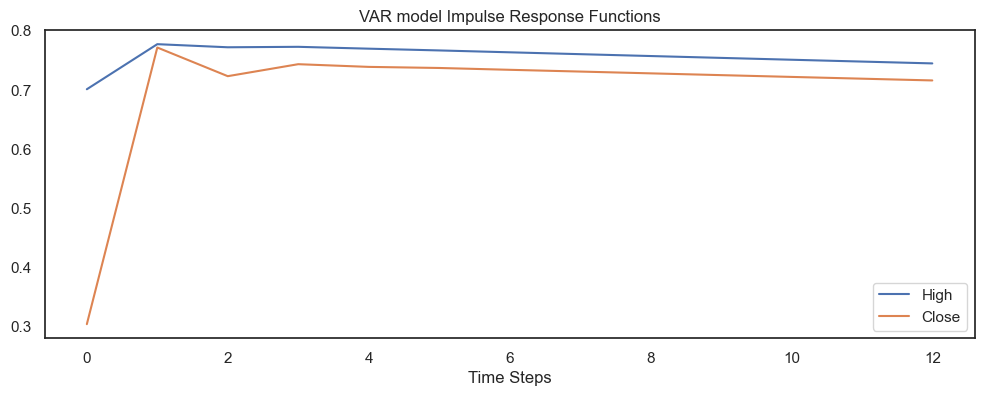

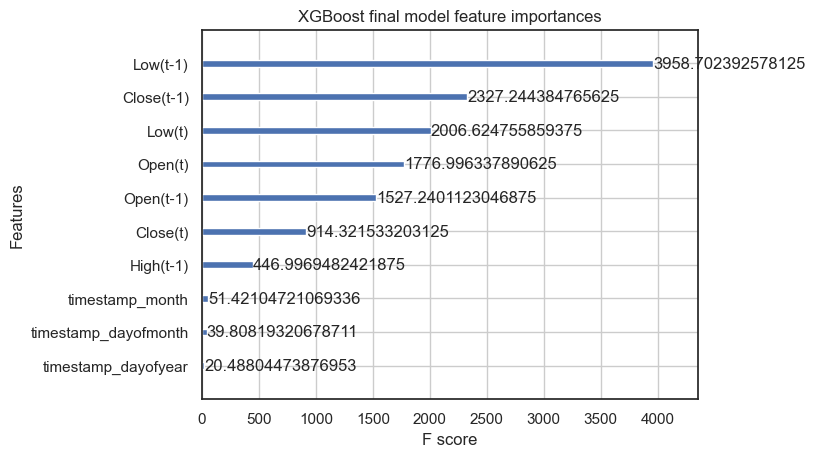

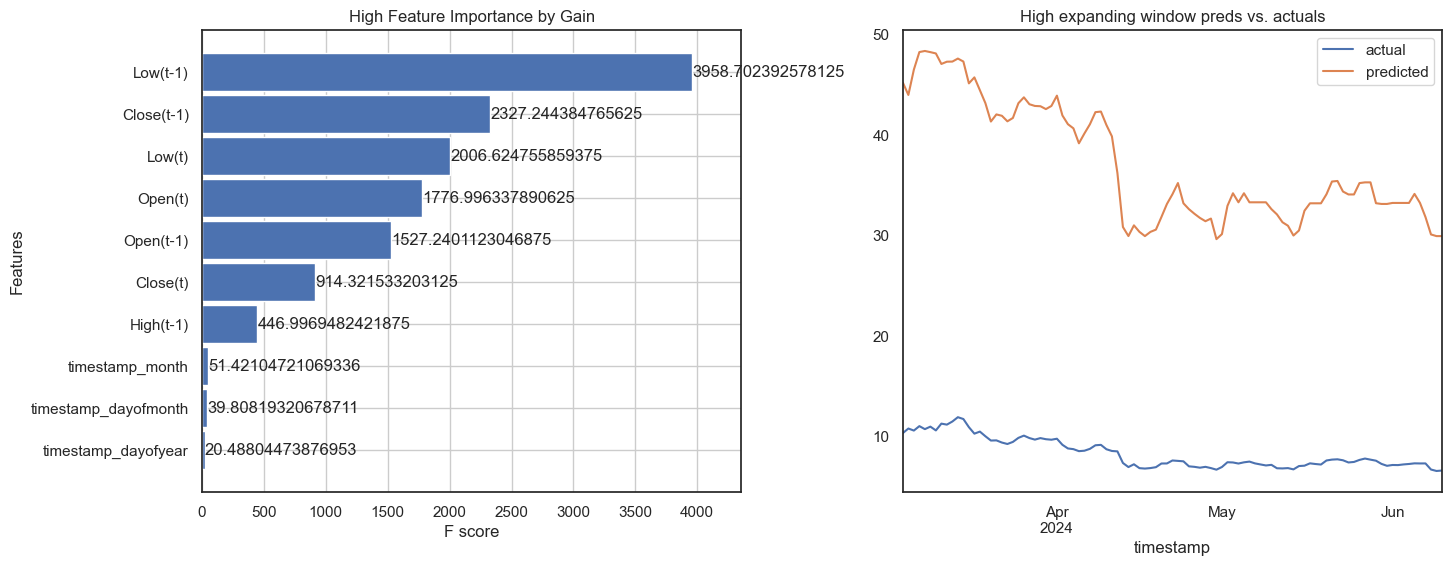

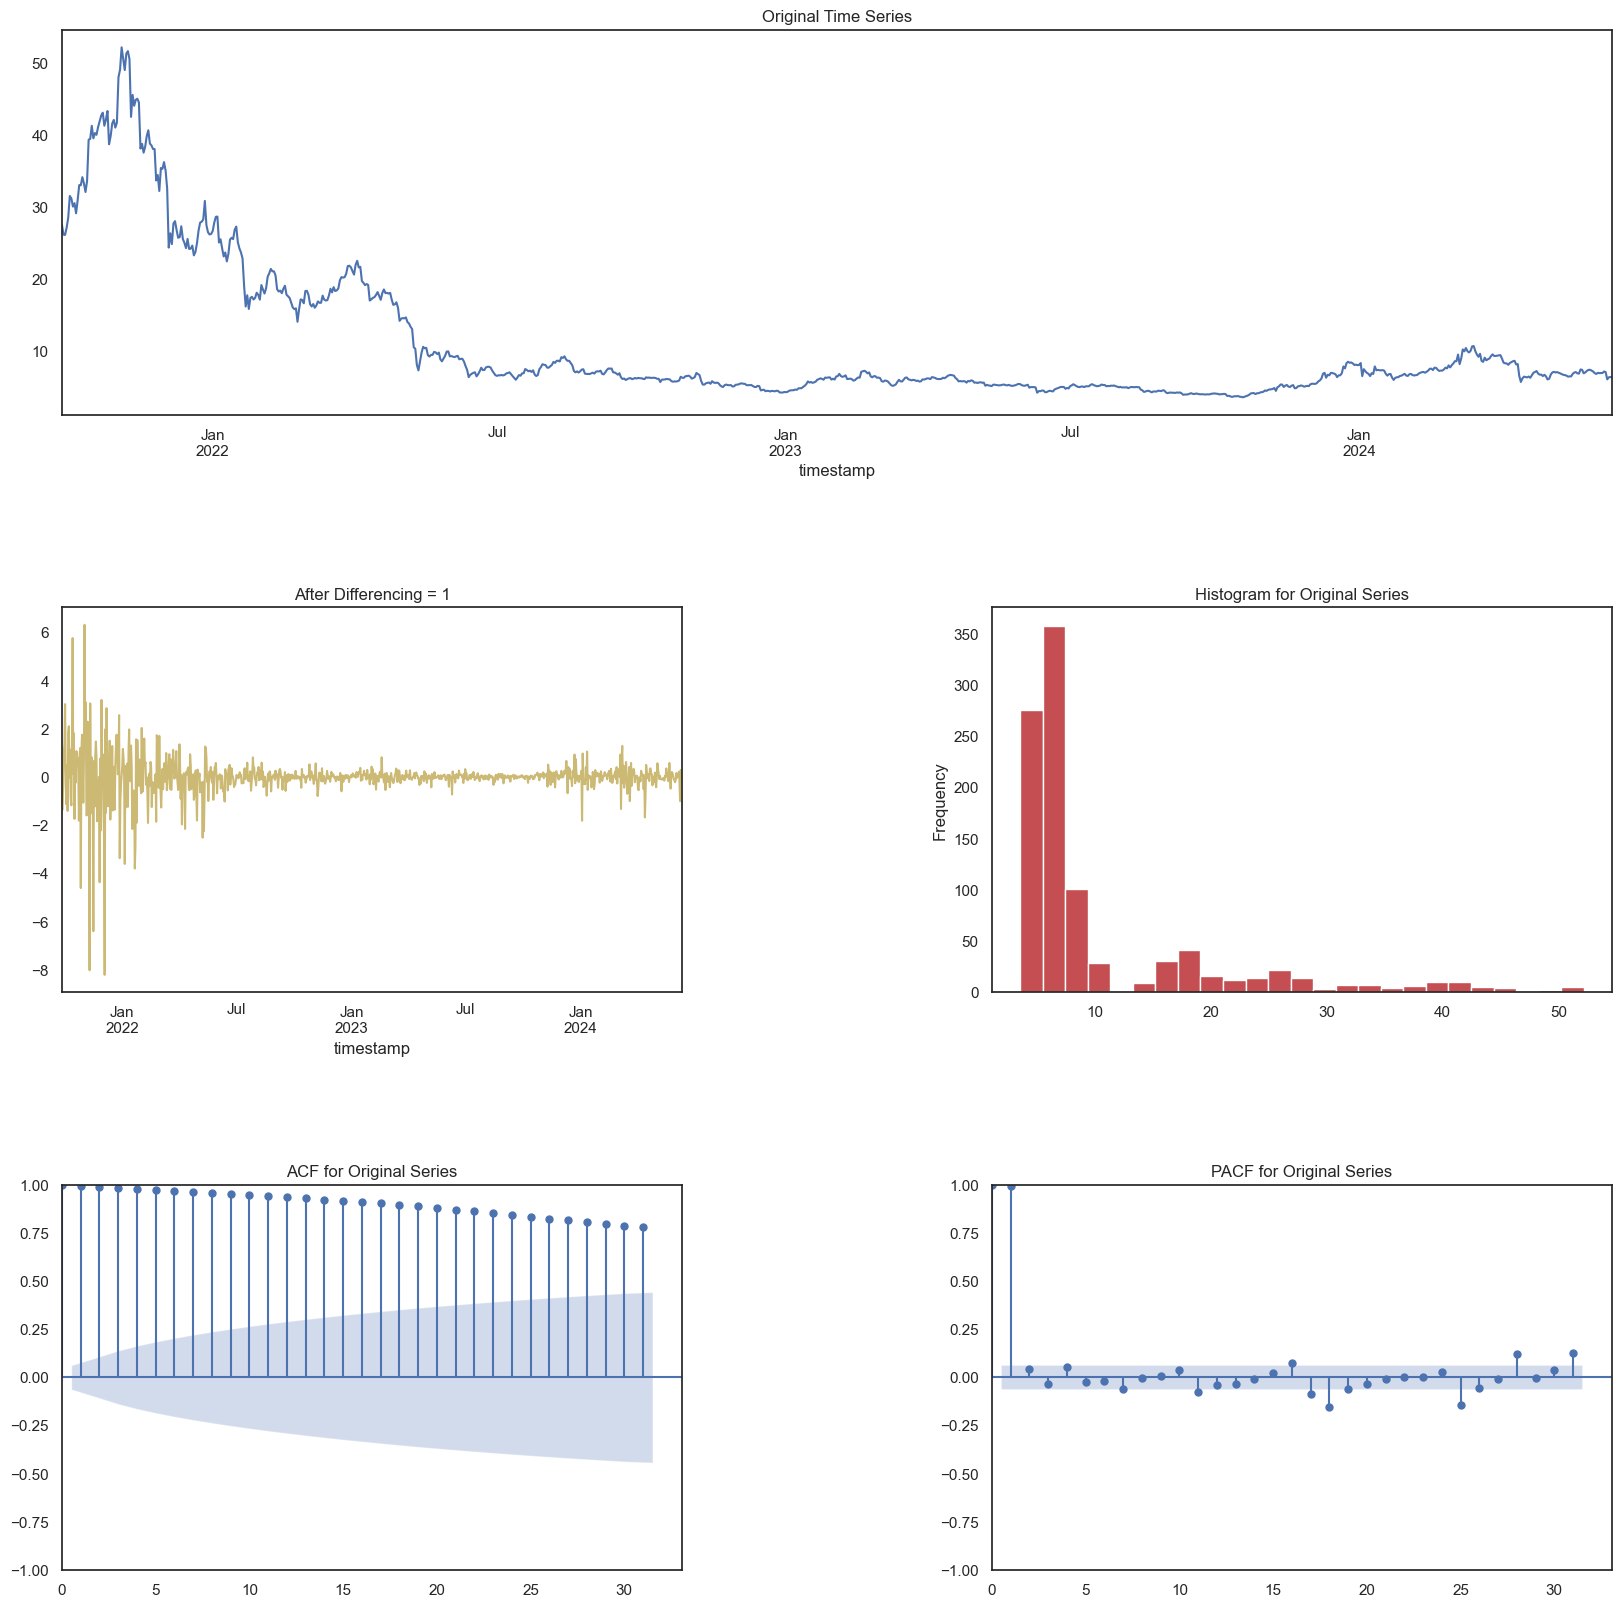

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...
Start of Fit.....
    Target variable given as = Low
Start of loading of data.....
    Inputs: ts_column = timestamp, sep = ,, target = ['Low']
    Using given input: pandas dataframe...
    timestamp column exists in given train data...
    train data shape = (988, 4)
Alert: Could not detect strf_time_format of timestamp. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


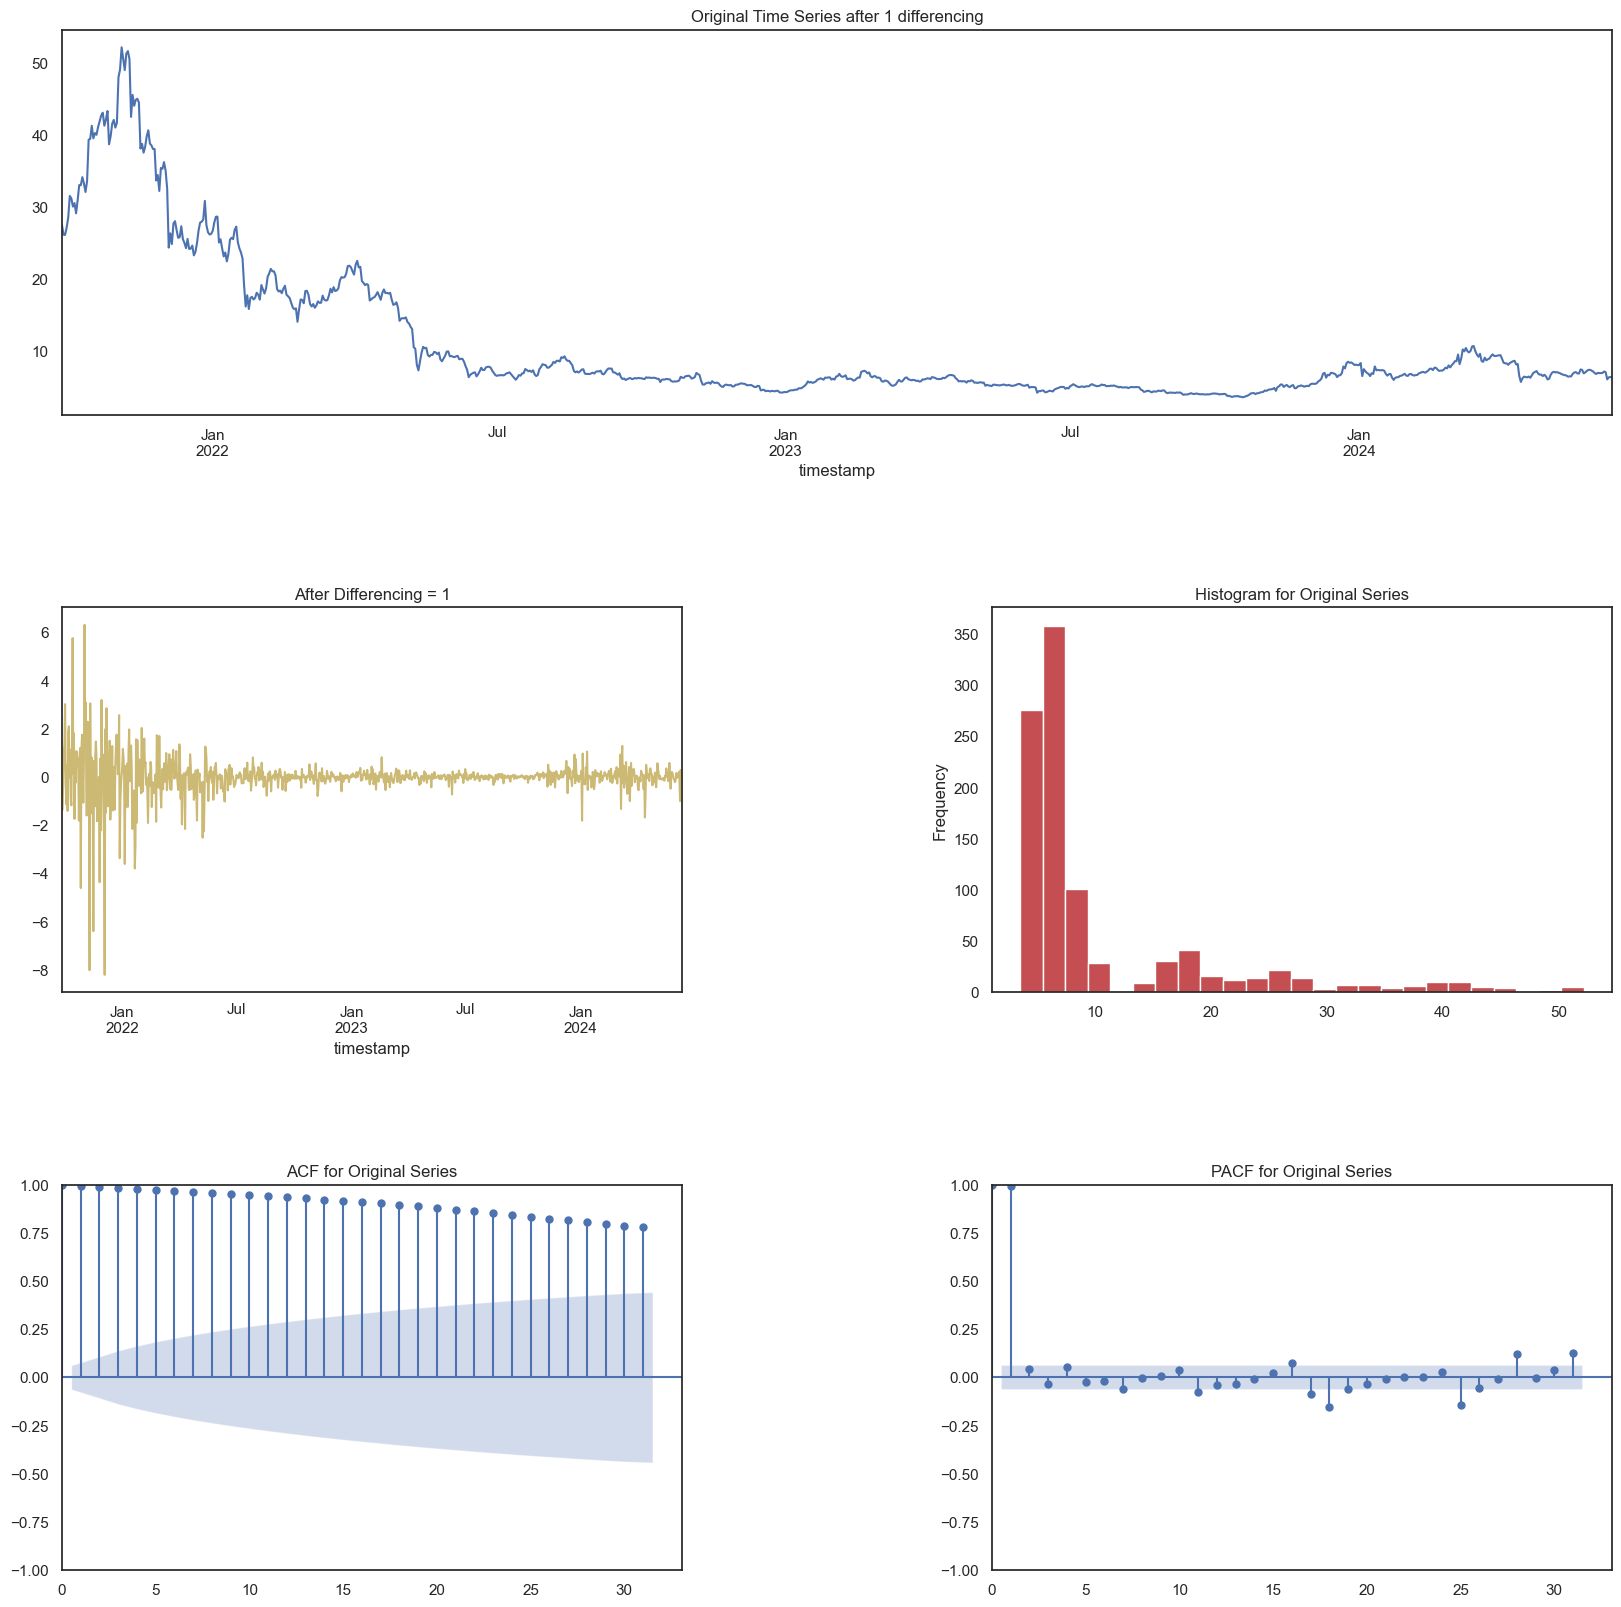

18:17:21 - cmdstanpy - INFO - Chain [1] start processing


Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(988, 5)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 2

Fold Number: 1 --> Train Shape: 968 Test Shape: 10


18:17:21 - cmdstanpy - INFO - Chain [1] done processing
18:17:21 - cmdstanpy - INFO - Chain [1] start processing


    RMSE = 1.08
    Std Deviation of actuals = 0.21
    Normalized RMSE (as pct of std dev) = 524%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 978 Test Shape: 10


18:17:22 - cmdstanpy - INFO - Chain [1] done processing


Exception occurred while building Prophet model...
'DataFrame' object has no attribute 'append'
    FB Prophet may not be installed or Model is not running...


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2364.367, Time=0.22 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2365.572, Time=0.22 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2365.638, Time=0.35 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2362.986, Time=0.11 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2345.398, Time=1.96 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2347.025, Time=2.29 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2347.026, Time=2.45 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2365.826, Time=0.40

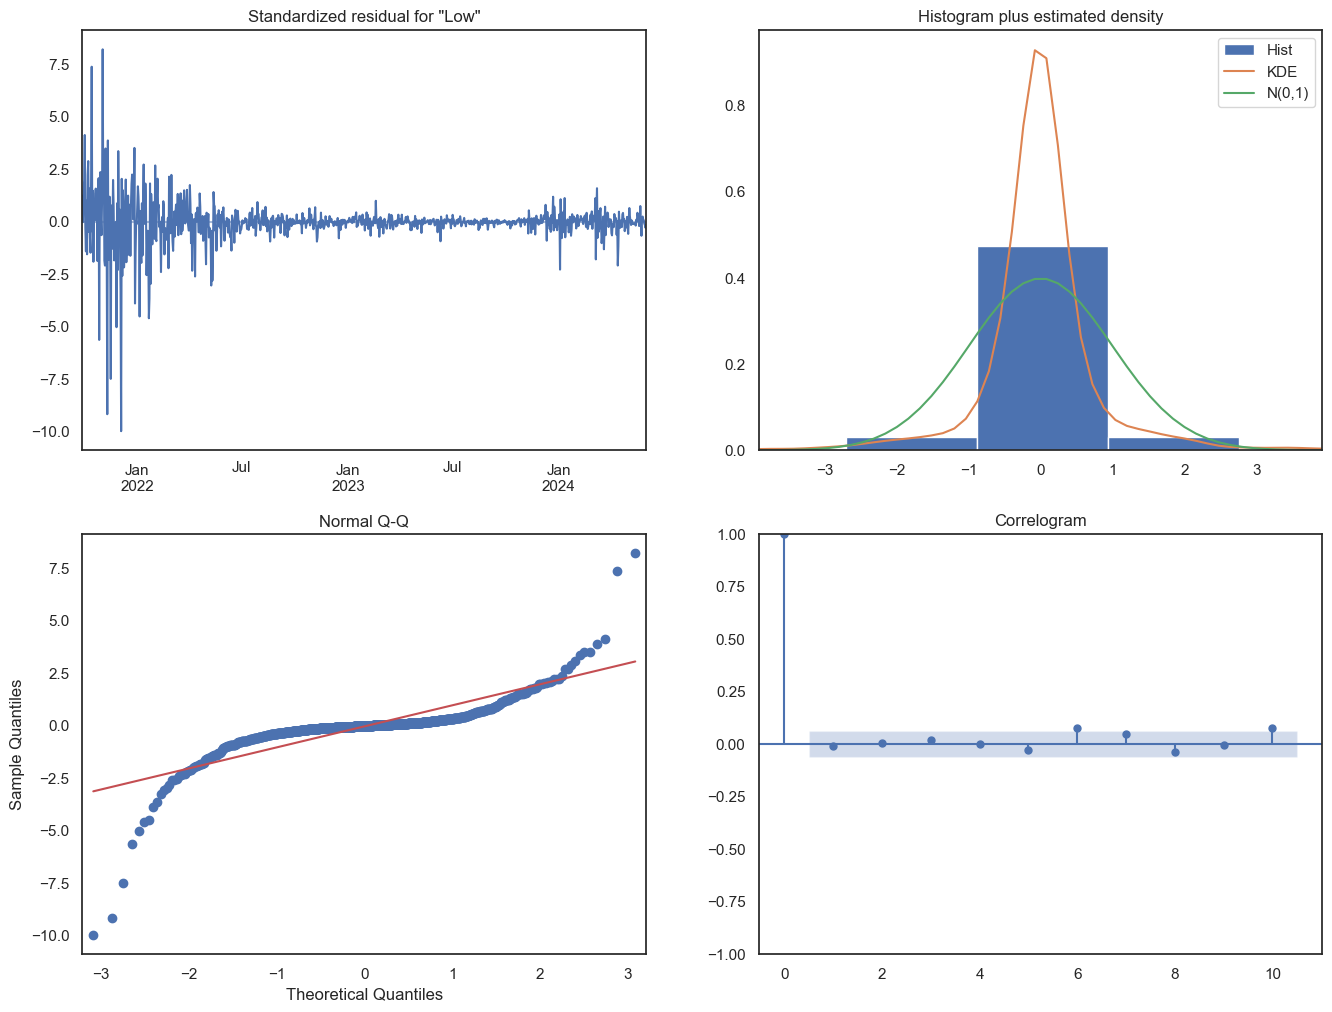

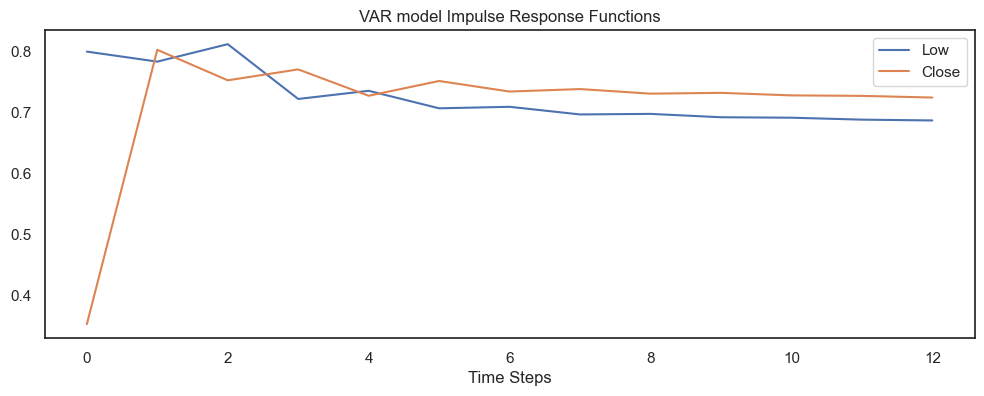

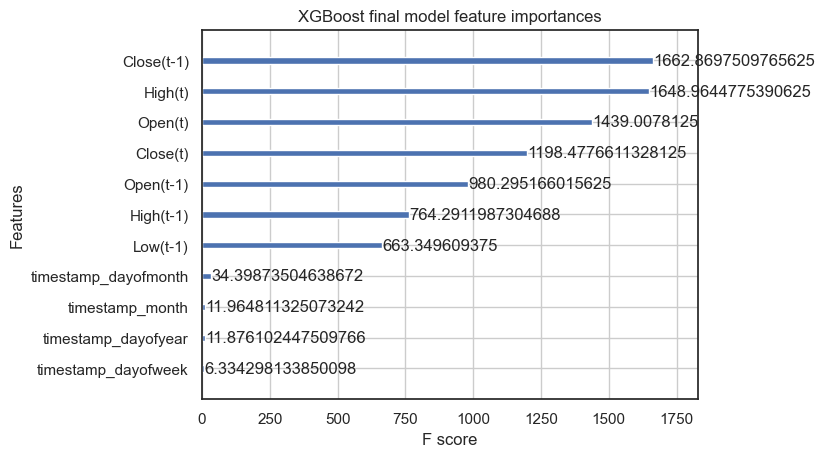

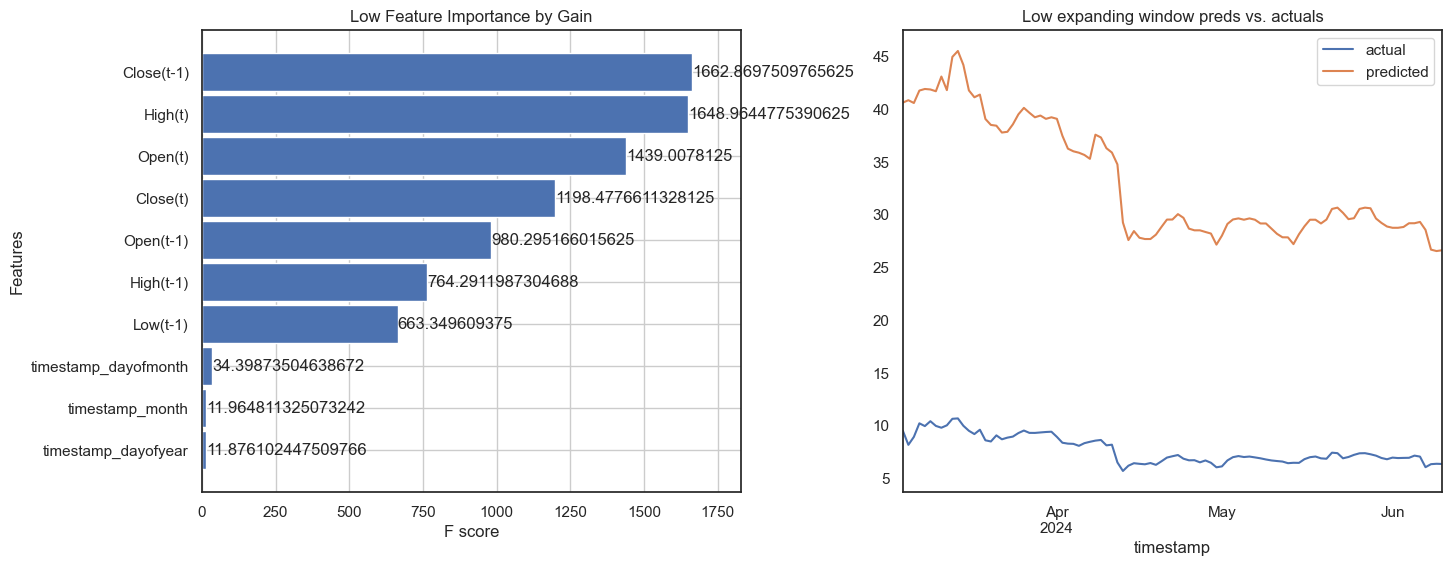

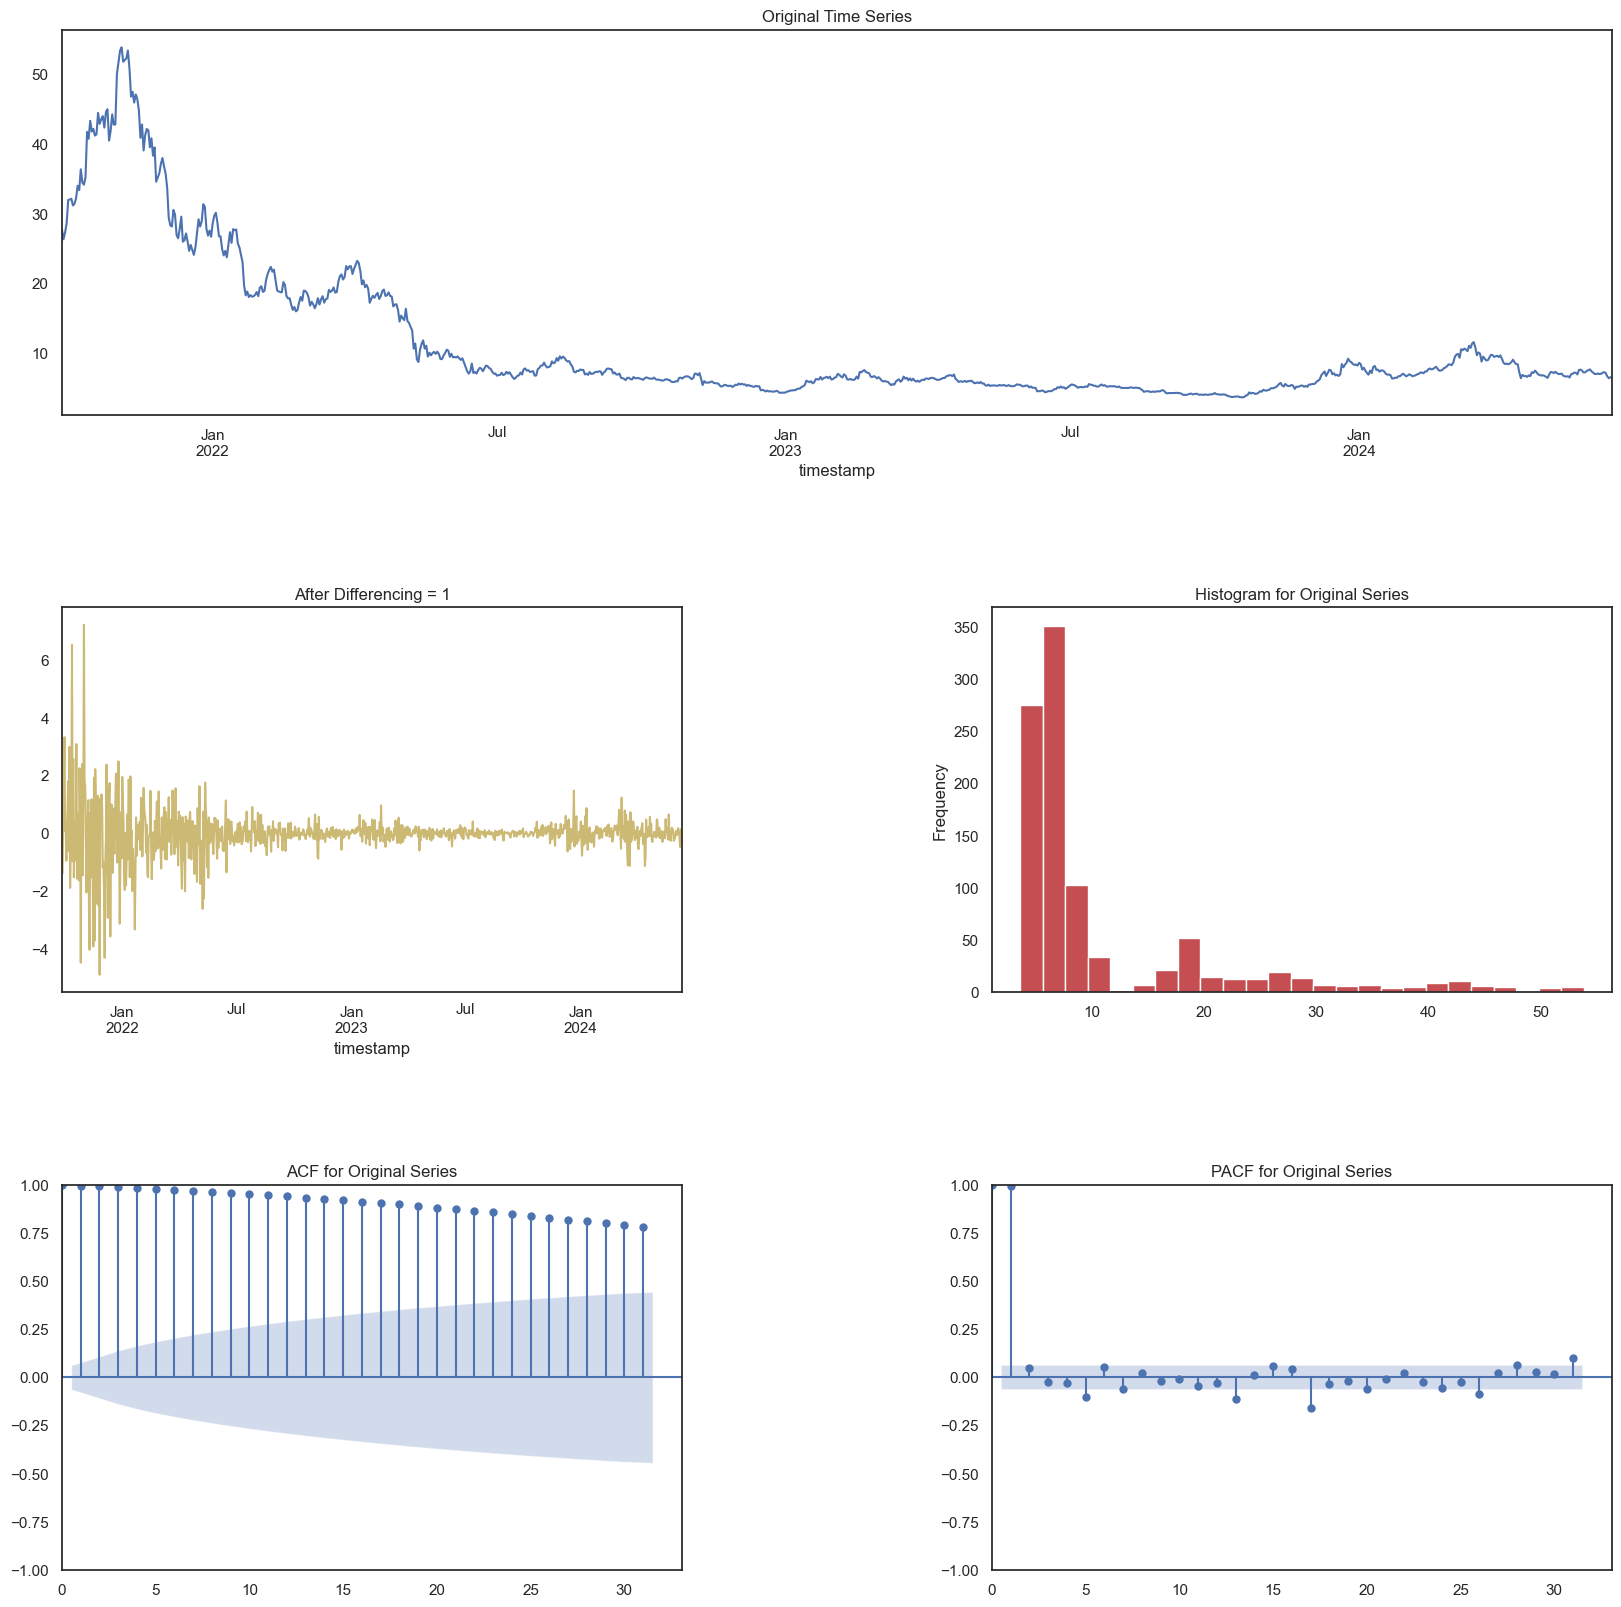

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...
Start of Fit.....
    Target variable given as = Close
Start of loading of data.....
    Inputs: ts_column = timestamp, sep = ,, target = ['Close']
    Using given input: pandas dataframe...
    timestamp column exists in given train data...
    train data shape = (988, 4)
Alert: Could not detect strf_time_format of timestamp. Provide strf_time format during "setup" for better results.

Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Data is stationary after one differencing
There is 1 differencing needed in this datasets for VAR model


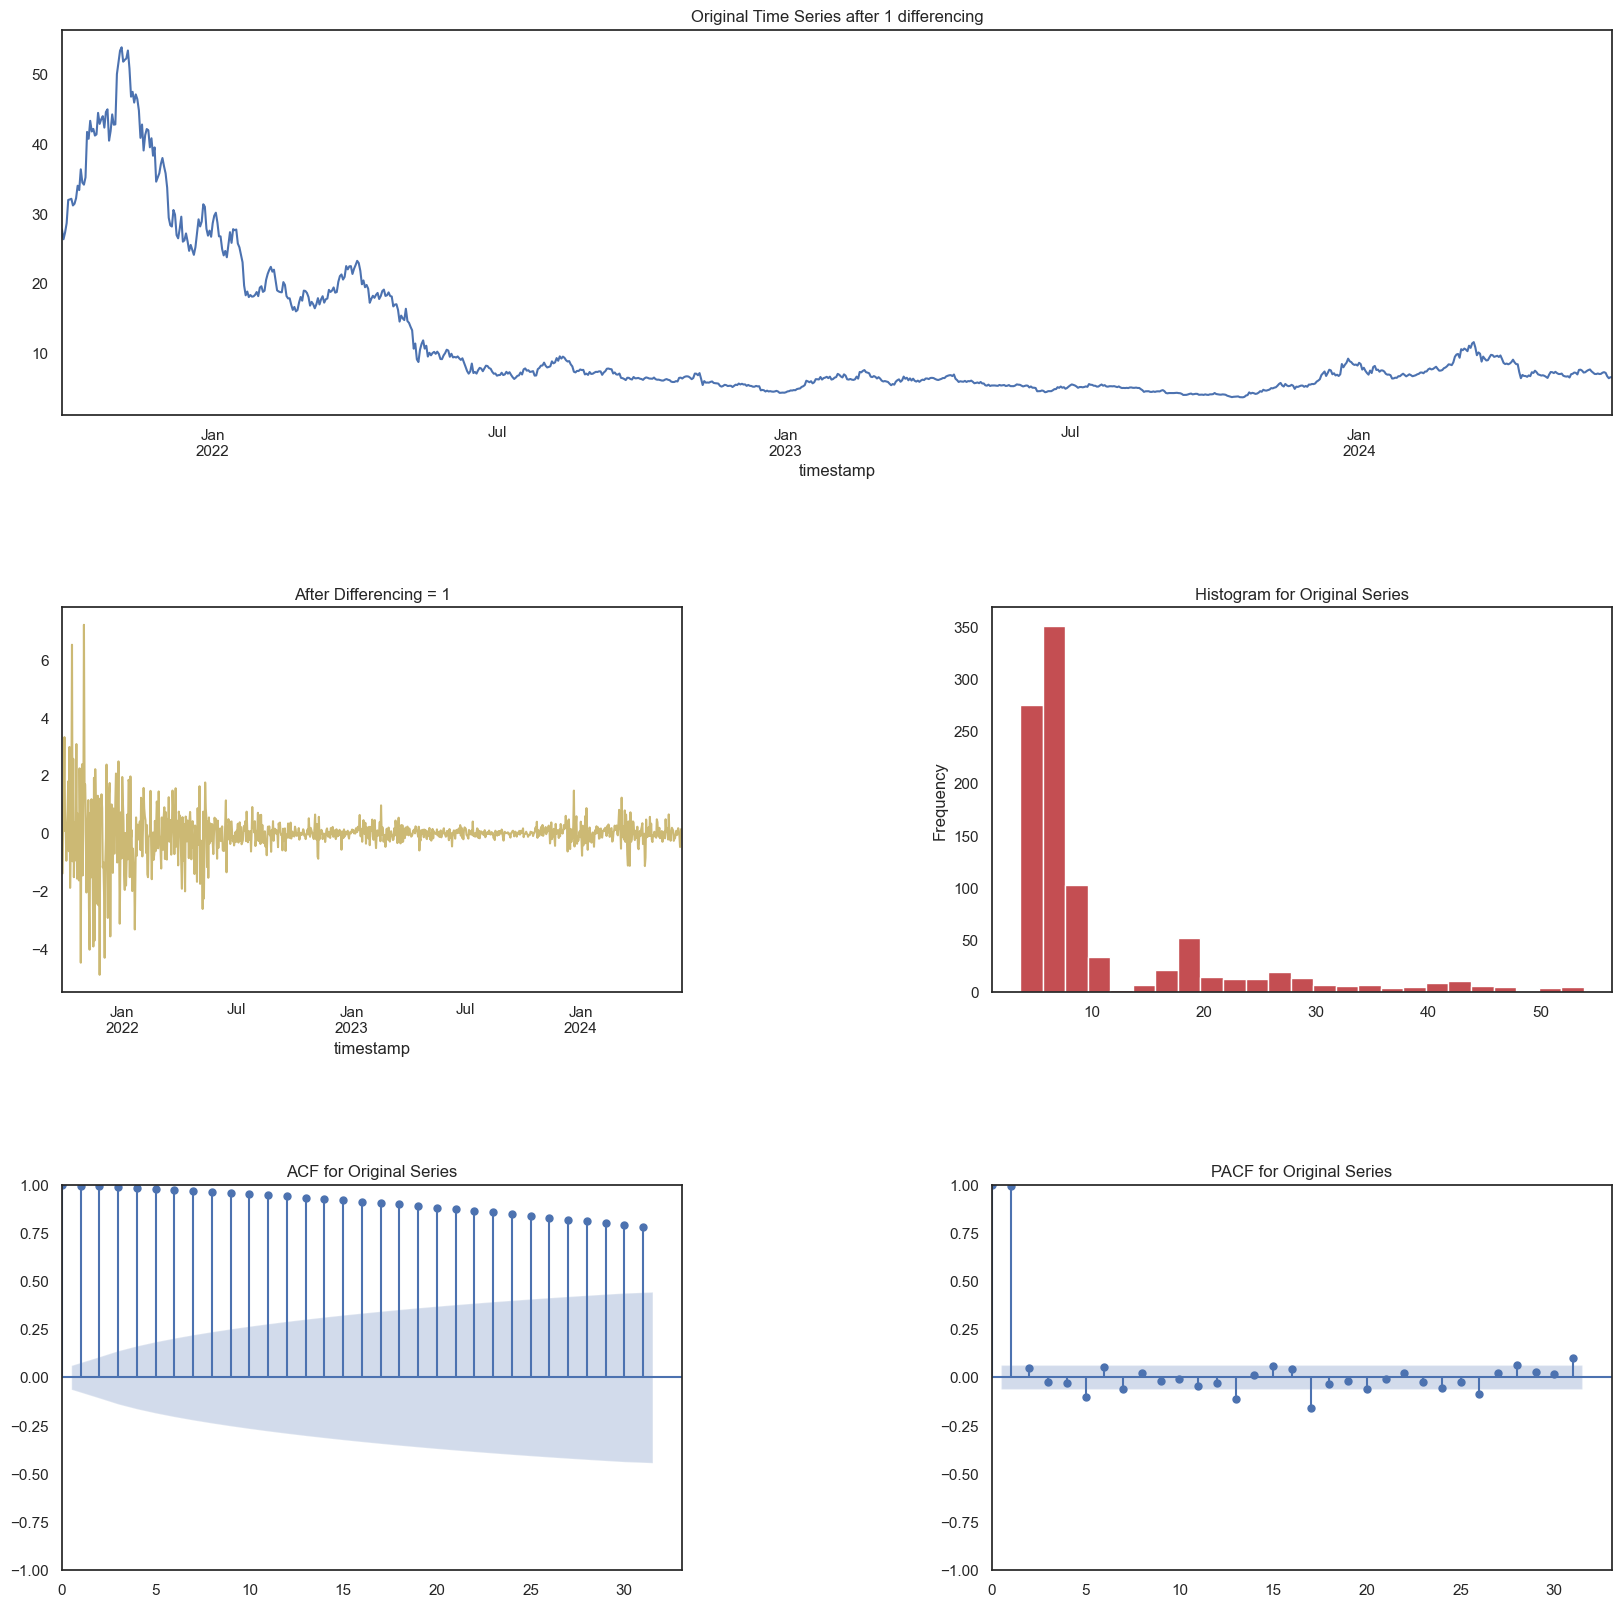

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building Prophet Model



Running Facebook Prophet Model...
kwargs for Prophet model: {'iter': 100}
    Fit-Predict data (shape=(988, 5)) with Confidence Interval = 0.95...
  Starting Prophet Fit
      No seasonality assumed since seasonality flag is set to False
  Starting Prophet Cross Validation
Max. iterations using expanding window cross validation = 2

Fold Number: 1 --> Train Shape: 968 Test Shape: 10


20:29:33 - cmdstanpy - INFO - Chain [1] start processing
20:29:33 - cmdstanpy - INFO - Chain [1] done processing
20:29:34 - cmdstanpy - INFO - Chain [1] start processing


    RMSE = 0.60
    Std Deviation of actuals = 0.21
    Normalized RMSE (as pct of std dev) = 281%
Cross Validation window: 1 completed

Fold Number: 2 --> Train Shape: 978 Test Shape: 10


20:29:34 - cmdstanpy - INFO - Chain [1] done processing


Exception occurred while building Prophet model...
'DataFrame' object has no attribute 'append'
    FB Prophet may not be installed or Model is not running...


Building Auto SARIMAX Model



Running Auto SARIMAX Model...


Best Parameters:
p: None, d: None, q: None
P: None, D: None, Q: None
Seasonality: False
Seasonal Period: 12

Fold Number: 1 --> Train Shape: 968 Test Shape: 10

    Finding the best parameters using AutoArima:
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2288.618, Time=0.17 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2289.118, Time=0.15 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=2289.148, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2287.289, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=2282.430, Time=0.60 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=2293.035, Time=0.23 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=2293.041, Time=0.24 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=2291.040, Time=0.21

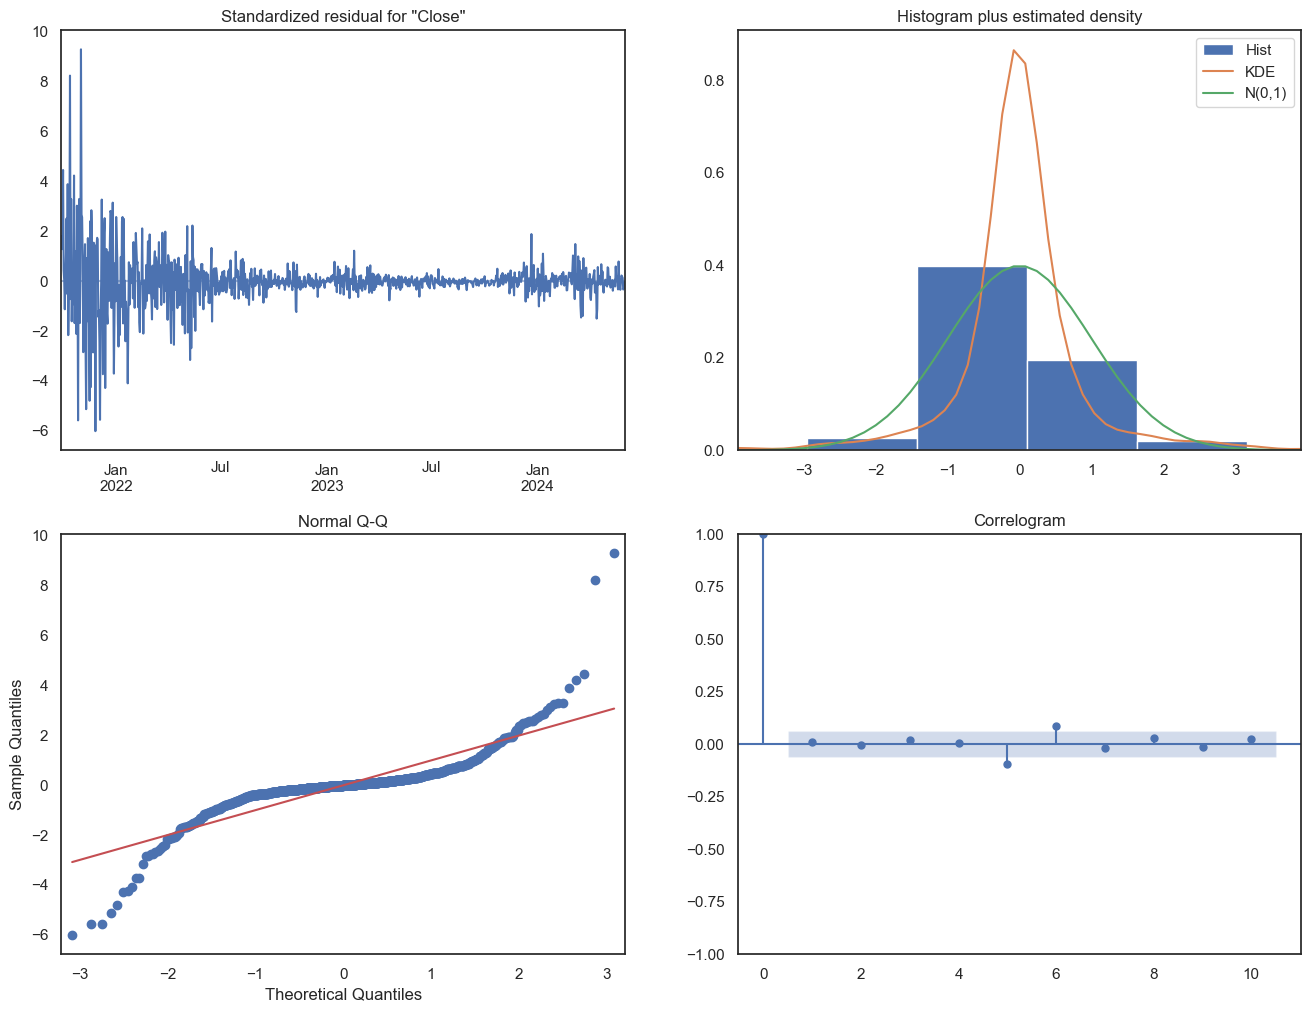

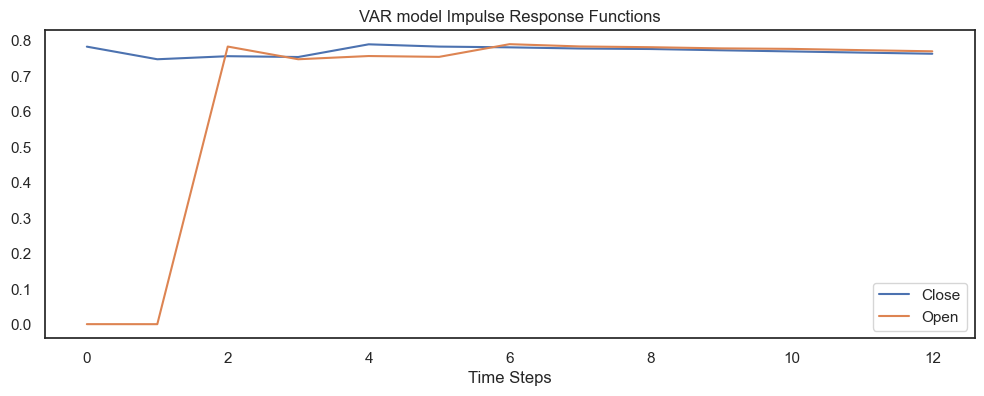

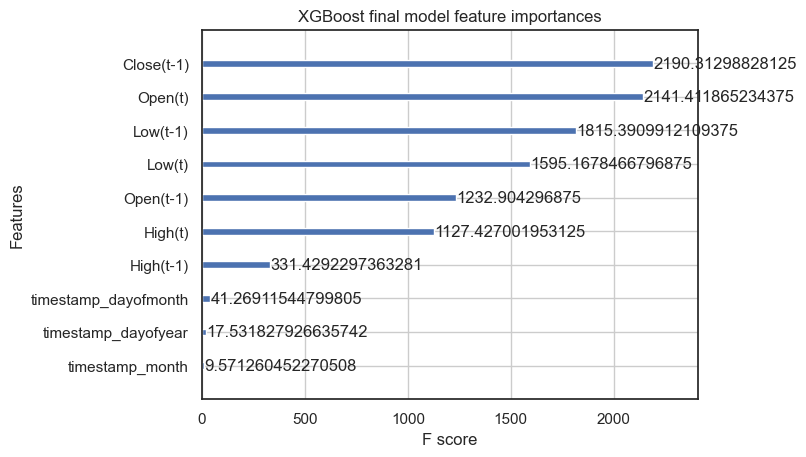

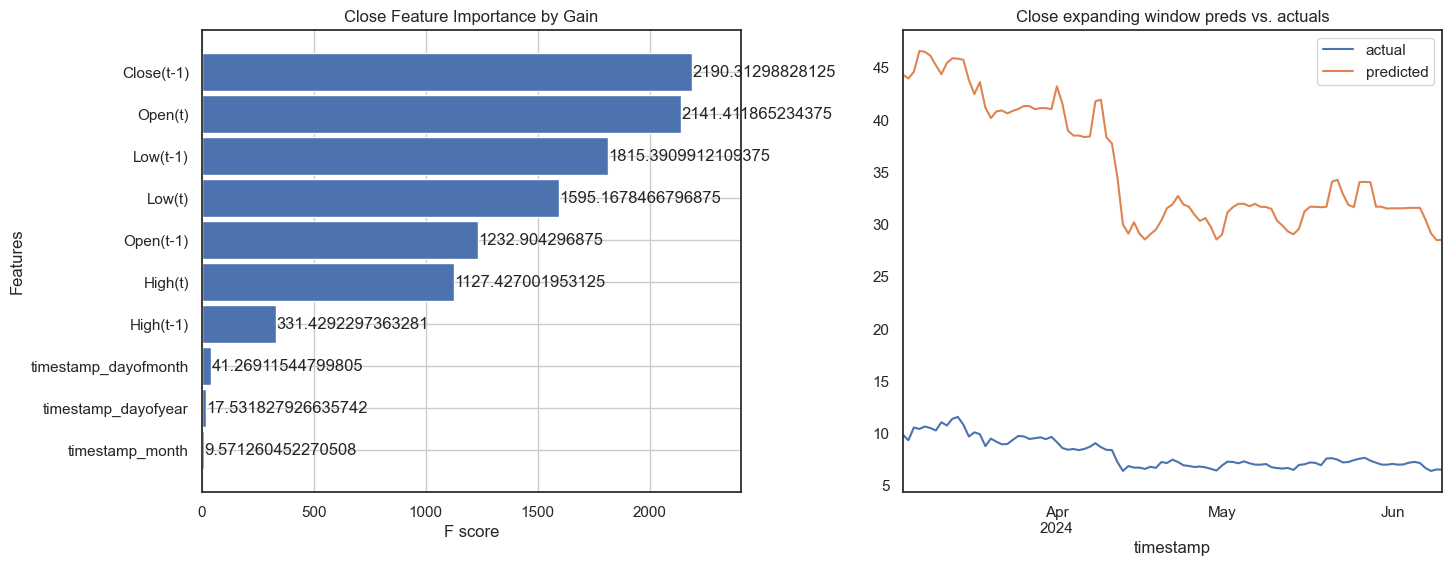

In [20]:
trained_models = {}

cv = 2
# Iterar sobre cada columna seleccionada
for column in columns_to_predict:
    # Excluir 'Open_time' del bucle de iteración
    if column != 'Open_time':
        model = auto_timeseries(score_type='rmse', time_interval='D',
                                non_seasonal_pdq=None, seasonality=False,
                                model_type='SARIMAX', verbose=2, forecast_period=n_days_to_predict)
        
        try:
            model.fit(features, ts_column='timestamp', target=column, cv=cv)
        except:
            model = auto_timeseries(score_type='rmse', time_interval='D',
                                non_seasonal_pdq=None, seasonality=False,
                                model_type='best', verbose=2, forecast_period=n_days_to_predict)
            model.fit(features, ts_column='timestamp', target=column, cv=cv)
        
        # Guardar el modelo en el diccionario
        trained_models[column] = model

#### Hago las predicciones a futuro

In [24]:
def calcular_indicadores_tecnicos(historico_precio):
    close_prices = np.array(historico_precio['Close'], dtype=np.double)
    high_prices = np.array(historico_precio['High'], dtype=np.double)
    low_prices = np.array(historico_precio['Low'], dtype=np.double)
    
    # Media Móvil Simple (SMA)
    sma_20 = talib.SMA(close_prices, timeperiod=20)
    
    # Media Móvil Exponencial (EMA)
    ema_20 = talib.EMA(close_prices, timeperiod=20)
    
    # Bandas de Bollinger
    upper_band, middle_band, lower_band = talib.BBANDS(close_prices, timeperiod=20, nbdevup=2, nbdevdn=2)
    
    # Índice de Fuerza Relativa (RSI)
    rsi = talib.RSI(close_prices, timeperiod=14)
    
    # MACD (Convergencia/Divergencia de Medias Móviles)
    macd, signal, _ = talib.MACD(close_prices, fastperiod=12, slowperiod=26, signalperiod=9)
    
    # ADX (Índice Direccional Promedio)
    adx = talib.ADX(high_prices, low_prices, close_prices, timeperiod=14)
    
    # Estocástico
    slowk, slowd = talib.STOCH(high_prices, low_prices, close_prices, fastk_period=14, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    
    # Índice de Canal de Materias Primas 
    cci = talib.CCI(high_prices, low_prices, close_prices, timeperiod=14)
    
    # ATR (Average True Range)
    atr = talib.ATR(high_prices, low_prices, close_prices, timeperiod=14)
    
    indicadores = pd.DataFrame({
        'SMA_20': sma_20,
        'EMA_20': ema_20,
        'Upper_Band': upper_band,
        'Middle_Band': middle_band,
        'Lower_Band': lower_band,
        'RSI': rsi,
        'MACD': macd,
        'Signal': signal,
        'ADX': adx,
        'SlowK': slowk,
        'SlowD': slowd,
        'CCI': cci,
        'ATR': atr
    }, index=historico_precio.index)
    
    return indicadores

In [25]:
forecast_results = {}

for column in columns_to_predict:
    future_predictions = trained_models[column].predict(testdata=10)
    forecast_results[column] = future_predictions
    # display(future_predictions)

# Mostrar los resultados del pronóstico
for column, predictions in forecast_results.items():
    print(f"Pronóstico para la columna '{column}':")
    display(pd.DataFrame(predictions))

Predicting using forecast period=10 as input for VAR model
Predicting using forecast period=10 as input for VAR model
Predicting using forecast period=10 as input for VAR model
Predicting using forecast period=10 as input for VAR model
Pronóstico para la columna 'Open':


Open,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-11,6.55,0.78,5.03,8.08
2024-06-12,6.58,1.08,4.47,8.69
2024-06-13,6.61,1.31,4.04,9.18
2024-06-14,6.63,1.51,3.67,9.59
2024-06-15,6.65,1.68,3.35,9.95
2024-06-16,6.67,1.84,3.07,10.27
2024-06-17,6.69,1.98,2.81,10.56
2024-06-18,6.70,2.11,2.57,10.83
2024-06-19,6.72,2.23,2.35,11.09
2024-06-20,6.74,2.34,2.15,11.33


Pronóstico para la columna 'High':


High,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-11,6.58,0.70,5.21,7.94
2024-06-12,6.60,1.04,4.56,8.65
2024-06-13,6.63,1.30,4.08,9.18
2024-06-14,6.66,1.51,3.70,9.63
2024-06-15,6.69,1.70,3.36,10.02
2024-06-16,6.72,1.86,3.07,10.37
2024-06-17,6.75,2.01,2.80,10.70
2024-06-18,6.78,2.15,2.56,11.00
2024-06-19,6.81,2.28,2.33,11.29
2024-06-20,6.84,2.41,2.13,11.55


Pronóstico para la columna 'Low':


Low,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-11,6.30,0.79,4.74,7.86
2024-06-12,6.29,1.11,4.11,8.46
2024-06-13,6.32,1.37,3.63,9.00
2024-06-14,6.35,1.55,3.31,9.38
2024-06-15,6.36,1.71,3.00,9.72
2024-06-16,6.38,1.85,2.75,10.02
2024-06-17,6.40,1.99,2.51,10.29
2024-06-18,6.42,2.10,2.30,10.55
2024-06-19,6.44,2.22,2.10,10.79
2024-06-20,6.46,2.32,1.91,11.01


Pronóstico para la columna 'Close':


Close,yhat,mean_se,mean_ci_lower,mean_ci_upper
2024-06-11,6.50,0.78,4.97,8.03
2024-06-12,6.49,1.08,4.38,8.61
2024-06-13,6.51,1.32,3.93,9.09
2024-06-14,6.52,1.51,3.55,9.48
2024-06-15,6.52,1.71,3.18,9.87
2024-06-16,6.53,1.88,2.85,10.21
2024-06-17,6.54,2.03,2.56,10.52
2024-06-18,6.55,2.17,2.29,10.81
2024-06-19,6.56,2.31,2.03,11.08
2024-06-20,6.56,2.43,1.80,11.33


In [26]:
for column, model in trained_models.items():
    # Guarda el modelo en un archivo usando dill
    with open(f"auto_ts_models/{column}.pkl", "wb") as file:
        dill.dump(model, file)

In [27]:
predictions_df = pd.DataFrame()

for column, predictions in forecast_results.items():
    predictions_df[column] = predictions['yhat'].values

fechas = [nueva_fecha + timedelta(days=i) for i in range(1, 11)]
df_fechas = pd.DataFrame({'timestamp': fechas})

# Añadir la columna de timestamp
predictions_df['Open_time'] = df_fechas['timestamp'].values

display(predictions_df)

,Open,High,Low,Close,Open_time
0,6.55,6.58,6.30,6.50,2024-06-11
1,6.58,6.60,6.29,6.49,2024-06-12
2,6.61,6.63,6.32,6.51,2024-06-13
3,6.63,6.66,6.35,6.52,2024-06-14
4,6.65,6.69,6.36,6.52,2024-06-15
5,6.67,6.72,6.38,6.53,2024-06-16
6,6.69,6.75,6.40,6.54,2024-06-17
7,6.70,6.78,6.42,6.55,2024-06-18
8,6.72,6.81,6.44,6.56,2024-06-19
9,6.74,6.84,6.46,6.56,2024-06-20


In [28]:
nuevo_df.tail()

,Open_time,Open,High,Low,Close,Volume,Quote asset volume,Number of trades,Open_BTCUSDT,High_BTCUSDT,Low_BTCUSDT,Close_BTCUSDT,Volume_BTCUSDT,Quote_asset_volume_BTCUSDT,Number_of_trades_BTCUSDT,Open_ETHUSDT,High_ETHUSDT,Low_ETHUSDT,Close_ETHUSDT,Volume_ETHUSDT,Quote_asset_volume_ETHUSDT,Number_of_trades_ETHUSDT,Open_BNBUSDT,High_BNBUSDT,Low_BNBUSDT,Close_BNBUSDT,Volume_BNBUSDT,Quote_asset_volume_BNBUSDT,Number_of_trades_BNBUSDT,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR,MFI,buy_1000x_high_coinbase,sell_1000x_high_coinbase,total_trades_coinbase,Sentimiento,Tweets_Utilizados,Cantidad_pos,Cantidad_neg,Cantidad_neu,Compound total,Sentimiento_coin,Tweets_Utilizados_coin,Cantidad_pos_coin,Cantidad_neg_coin,Cantidad_neu_coin,Compound total coin,Sentimiento_referentes,Tweets_Utilizados_referentes,Cantidad_pos_referentes,Cantidad_neg_referentes,Cantidad_neu_referentes,Compound total referentes,Tweets_Utilizados_whale_alert,Buy_1000x_high,sell_1000x_high,total_trades_binance,Tendencia
983,2024-06-06,7.25,7.29,7.06,7.14,2433999.18,17531588.67,59115.00,71108.00,71700.00,70117.64,70799.06,21842.00,1551467659.15,900226.00,3866.00,3878.60,3760.00,3813.46,237504.19,910751773.18,525050.00,698.80,721.80,692.00,711.20,544042.96,383971667.05,424589.00,7.25,7.17,7.70,7.25,6.80,49.02,-0.02,-0.01,13.91,39.88,33.79,-22.62,0.32,45.41,12.00,18.00,27918.00,pos,526.00,240.00,87.00,199.00,78.16,pos,370.00,197.00,55.00,118.00,78.01,neu,0.00,0.00,0.00,0.00,0.00,35.00,174.00,138.00,36000.00,Lateral
984,2024-06-07,7.14,7.29,6.05,6.66,8416185.59,56571253.45,206977.00,70799.06,71997.02,68420.00,69355.60,35598.45,2507250591.33,1516415.00,3813.47,3841.39,3600.00,3678.32,362223.36,1352307567.24,894006.00,711.10,712.00,658.90,684.00,594753.99,411647370.98,467676.00,7.22,7.12,7.74,7.22,6.71,38.78,-0.06,-0.02,16.12,38.79,37.98,-173.61,0.38,41.65,33.00,22.00,58526.00,pos,521.00,251.00,96.00,174.00,86.76,pos,299.00,136.00,49.00,114.00,51.62,neu,0.00,0.00,0.00,0.00,0.00,29.00,413.00,301.00,126000.00,Bajista
985,2024-06-08,6.66,6.68,6.34,6.38,3615115.34,23479748.53,90111.00,69355.60,69582.20,69168.02,69310.46,9773.83,678267390.53,714103.00,3678.31,3709.50,3660.08,3681.57,140550.84,518118534.04,364485.00,684.00,694.90,677.90,682.70,216849.47,148522259.27,226469.00,7.20,7.05,7.82,7.20,6.57,34.39,-0.11,-0.04,18.18,29.83,36.17,-193.31,0.38,36.43,16.00,26.00,35817.00,pos,380.00,161.00,79.00,140.00,43.71,pos,282.00,142.00,45.00,95.00,54.38,neu,0.00,0.00,0.00,0.00,0.00,16.00,266.00,200.00,57000.00,Bajista
986,2024-06-09,6.38,6.54,6.38,6.53,2659717.39,17204100.31,61660.00,69310.46,69857.14,69130.24,69648.14,9890.57,687344656.07,575583.00,3681.58,3721.52,3666.36,3706.40,103451.10,381854484.96,287960.00,682.70,684.80,670.30,673.00,173565.78,117580243.22,205290.00,7.14,7.00,7.80,7.14,6.48,38.30,-0.14,-0.06,20.08,27.31,31.98,-160.37,0.37,35.56,6.00,4.00,18355.00,pos,377.00,173.00,65.00,139.00,63.07,pos,344.00,158.00,61.00,125.00,60.90,neu,0.00,0.00,0.00,0.00,0.00,5.00,173.00,192.00,40000.00,Alcista
987,2024-06-10,6.53,6.58,6.36,6.51,2942181.04,19083975.96,78223.00,69648.15,70195.94,69172.29,69540.00,17122.67,1192466549.97,936731.00,3706.40,3713.67,3642.74,3667.85,156363.18,575211243.30,391165.00,673.10,674.80,613.30,625.10,692122.62,443628428.25,698508.00,7.09,6.95,7.77,7.09,6.41,39.48,-0.12,-0.02,18.15,24.94,27.36,-127.13,0.35,33.97,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,Lateral


In [29]:
final_df = pd.concat([nuevo_df[['Open_time'] + columns_to_predict], predictions_df], ignore_index=True)

In [30]:
final_df['Open_time'] = pd.to_datetime(final_df['Open_time']).dt.date
display(final_df.tail(15))

,Open_time,Open,High,Low,Close
983,2024-06-06,7.25,7.29,7.06,7.14
984,2024-06-07,7.14,7.29,6.05,6.66
985,2024-06-08,6.66,6.68,6.34,6.38
986,2024-06-09,6.38,6.54,6.38,6.53
987,2024-06-10,6.53,6.58,6.36,6.51
988,2024-06-11,6.55,6.58,6.30,6.50
989,2024-06-12,6.58,6.60,6.29,6.49
990,2024-06-13,6.61,6.63,6.32,6.51
991,2024-06-14,6.63,6.66,6.35,6.52
992,2024-06-15,6.65,6.69,6.36,6.52


In [31]:
indicadores_tecnicos = calcular_indicadores_tecnicos(final_df)
display(indicadores_tecnicos)

,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,6.82,6.75,7.45,6.82,6.18,39.20,-0.18,-0.15,26.52,37.73,37.10,-37.23,0.34
994,6.77,6.73,7.36,6.77,6.18,39.58,-0.18,-0.16,26.68,38.36,37.76,-26.91,0.34
995,6.74,6.72,7.31,6.74,6.18,39.96,-0.17,-0.16,26.63,39.01,38.37,-12.60,0.34
996,6.72,6.70,7.28,6.72,6.16,40.38,-0.16,-0.16,26.37,39.77,39.05,19.87,0.35


In [32]:
ultimos_indicadores = indicadores_tecnicos.tail(10)
ultimos_indicadores = ultimos_indicadores.reset_index(drop=True)
merged_last_10 = pd.concat([predictions_df, ultimos_indicadores], axis=1)
display(merged_last_10)

,Open,High,Low,Close,Open_time,SMA_20,EMA_20,Upper_Band,Middle_Band,Lower_Band,RSI,MACD,Signal,ADX,SlowK,SlowD,CCI,ATR
0,6.55,6.58,6.30,6.50,2024-06-11,7.04,6.91,7.74,7.04,6.34,38.00,-0.17,-0.09,22.17,28.41,26.89,-106.31,0.35
1,6.58,6.60,6.29,6.49,2024-06-12,7.00,6.87,7.74,7.00,6.27,37.89,-0.18,-0.11,23.54,31.06,28.14,-87.67,0.35
2,6.61,6.63,6.32,6.51,2024-06-13,6.97,6.83,7.73,6.97,6.21,38.39,-0.19,-0.12,24.66,33.92,31.13,-70.15,0.35
3,6.63,6.66,6.35,6.52,2024-06-14,6.92,6.80,7.68,6.92,6.17,38.61,-0.19,-0.14,25.52,36.41,33.79,-57.02,0.34
4,6.65,6.69,6.36,6.52,2024-06-15,6.87,6.78,7.58,6.87,6.16,38.90,-0.19,-0.15,26.13,37.17,35.83,-46.74,0.34
5,6.67,6.72,6.38,6.53,2024-06-16,6.82,6.75,7.45,6.82,6.18,39.20,-0.18,-0.15,26.52,37.73,37.10,-37.23,0.34
6,6.69,6.75,6.40,6.54,2024-06-17,6.77,6.73,7.36,6.77,6.18,39.58,-0.18,-0.16,26.68,38.36,37.76,-26.91,0.34
7,6.70,6.78,6.42,6.55,2024-06-18,6.74,6.72,7.31,6.74,6.18,39.96,-0.17,-0.16,26.63,39.01,38.37,-12.60,0.34
8,6.72,6.81,6.44,6.56,2024-06-19,6.72,6.70,7.28,6.72,6.16,40.38,-0.16,-0.16,26.37,39.77,39.05,19.87,0.35
9,6.74,6.84,6.46,6.56,2024-06-20,6.70,6.69,7.25,6.70,6.15,40.82,-0.15,-0.16,25.93,40.52,39.77,106.54,0.35


In [33]:
merged_last_10.to_csv('auto_ts_models/result.csv', index=False)

#### Clasificacion

In [34]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321.

 connected.


H2O_cluster_uptime:,5 hours 27 mins
H2O_cluster_timezone:,America/Argentina/Buenos_Aires
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.2
H2O_cluster_version_age:,29 days
H2O_cluster_name:,H2O_from_python_mmarchetta_2j4nwx
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.331 Gb
H2O_cluster_total_cores:,16
H2O_cluster_allowed_cores:,16
H2O_cluster_status:,"locked, healthy"


In [35]:
stack_models = []
for i in range(5):
    model_path = f"automl_classifier/modelo_{i}.h2o"
    model = h2o.load_model(model_path)
    stack_models.append(model)

In [36]:
scaler = MinMaxScaler()
scaler.fit_transform(nuevo_df[columns])

array([[0.50200275, 0.51720786, 0.49257171, ..., 0.32081933, 0.39135415,
        0.97743099],
       [0.47968355, 0.48065332, 0.46458702, ..., 0.21571971, 0.353492  ,
        0.9457871 ],
       [0.45158526, 0.48473654, 0.46396971, ..., 0.14173471, 0.38052016,
        0.92071527],
       ...,
       [0.05998286, 0.05877892, 0.05712169, ..., 0.34782771, 0.21641068,
        0.06669395],
       [0.0545027 , 0.05599844, 0.05788304, ..., 0.30049182, 0.27026105,
        0.06282378],
       [0.05735238, 0.05681509, 0.05751265, ..., 0.24833548, 0.32459604,
        0.06004891]])

In [37]:
auto_ml_feature_predictor_df = pd.read_csv('auto_ts_models/result.csv')


features = auto_ml_feature_predictor_df[columns]
features_scaled = scaler.transform(features)

features_scaled = pd.DataFrame(features_scaled, columns=columns)
h2o_df = h2o.H2OFrame(features_scaled)
predictions = stack_models[0].predict(h2o_df)

display(predictions)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


predict,Alcista,Bajista,Lateral
Lateral,0.0338992,0.12949,0.83661
Bajista,0.0117434,0.777559,0.210697
Bajista,0.00642568,0.942643,0.0509311
Bajista,0.00657081,0.952551,0.0408785
Bajista,0.00753954,0.970638,0.0218225
Bajista,0.0070825,0.976577,0.0163405
Bajista,0.00700297,0.977514,0.0154833
Bajista,0.00607627,0.973401,0.0205228
Bajista,0.00513425,0.974937,0.0199289
Bajista,0.00514983,0.9637,0.0311498
